# Projeto - Avaliação de Técnicas de Aprendizado de Máquina em um Problema de Classificação

<br> 

### 1.0 Introdução

<br>

<font size=4.25>

<p style='text-align: justify;'>
Os problemas de classificação em aprendizado de máquina são caracterizados quando um objeto necessita ser classificado em uma classe ou grupo predefinido com base nos atributos desse objeto [1]. Diversos problemas diários pode ser categorizados como problemas de classificação, tais como: previsão do tempo, reconhecimento de manuscritos,controle de qualidade, entre outros. 
<p/>
    
 <p style='text-align: justify;'>
Geralmente os problemas de classificação são divididos em duas categorias: classificação binária e multiclasse. Enquanto um problema binário é um situação na qual o resultados previsto deve ser determinado como um decisão de 'Sim' ou 'Não', um problema multiclasse é uma condição em que o resultado previsto tem como decisão múltiplas respostas [2]. 
<p/>
    
 <p style='text-align: justify;'>
Embora os problemas de classificação possuam um objetivo simples, uma solução adequada para problemas dessa natureza passa necessariamente pela seleção de técnicas de aprendizado de máquina que melhor se adeque aos dados utilizados. Assim sendo, ao se abordar um problema de classificação é fundamental que mais de uma técnica de aprendizado de máquina seja testada. 
<p/>
    
 <p style='text-align: justify;'>
Diante disso, esse trabalho tem como objetivo a avaliação de algumas técnicas de aprendizado de máquina na classificação de rochas e minas a partir de dados de sinais de sonar (disponível em [3]). Dentre as técnicas de aprendizado de máquina, as seguinte serão analisadas:
<p/>
    
    
<ol>
<li> Redes Neurais (<em>Multilayer Percepton - MLP) </li>
<li>Máquinas de Vetor Suporte</li>
<li>K Vizinhos mais próximos</li>
</ol>
   
 <p style='text-align: justify;'>    
Salienta-se que as técnicas de rede neurais e k vizinhos mais próximos foram produzidos do zero, somente utilizando bibliotecas mais primitivas tais como numpy e pandas. 
<p/>

### 1.1 Descrição dos dados utilizados

<br>

<font size=4.25>

<p style='text-align: justify;'>
O banco de dados utilizado para a avaliação das técnicas de aprendizado de máquina trata-se do mesmo utilizado em [4], que é composto por dados de sinais de sonar para a classificação de minas (cilindros metálicos) e rochas de tamanho equivalente no assoalho marinho. Conforme indica em [4] bem como o diagrama da Figura abaixo, os sinais de sonar obtidos em campo foram filtrados e a informação espectral extraída foi utilizada como dado de entrada nas redes neurais avaliadas pelos autores. Após o processamento, cada amostra utilizada era composta por um total de 60 valores no intervalo entre 0 e 1, sendo cada um deles representativo da energia compreendida pelas bandas de frequência integrado ao longo do tempo. 
<p/>
    
<img src=dado_processado.png>
    
<font size=4.25>

<p style='text-align: justify;'>
Ao todo, o banco de dados possui 206 amostras, sendo 111 de rocha e 97 de mina. Conforme apresenta os histogramas abaixo, os atributos de entrada - energia compreendida pelas bandas de frequência - em alguns casos estão mais associados a uma das classes do que outra. Este é o caso dos atributos 2 e 3, onde os valores mais diminutos de energia estão usualmente relacionados à classe Rocha (em Azul). Por outro lado, quando se observa os atributos 11 e 12, constata-se que os menores valores de energia estão associados à classe Mina (em Laranja).  
<p/>

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
       <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
       <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>,
       <Axes: title={'center': '16'}>, <Axes: title={'center': '17'}>,
       <Axes: title={'center': '18'}>, <Axes: title={'center': '19'}>,
       <Axes: title={'center': '20'}>, <Axes: title={'center': '21'}>,
       <Axes: title={'center': '22'}>, <Axes: title={'center': '23'}>,
       <Axes: title={'center': '24'}>, <Axes: title={'center': '25'}>,
       <Axes: title={'center': '26'}>, <Axes: title={'center': '27'}>,
       <Axes: ti

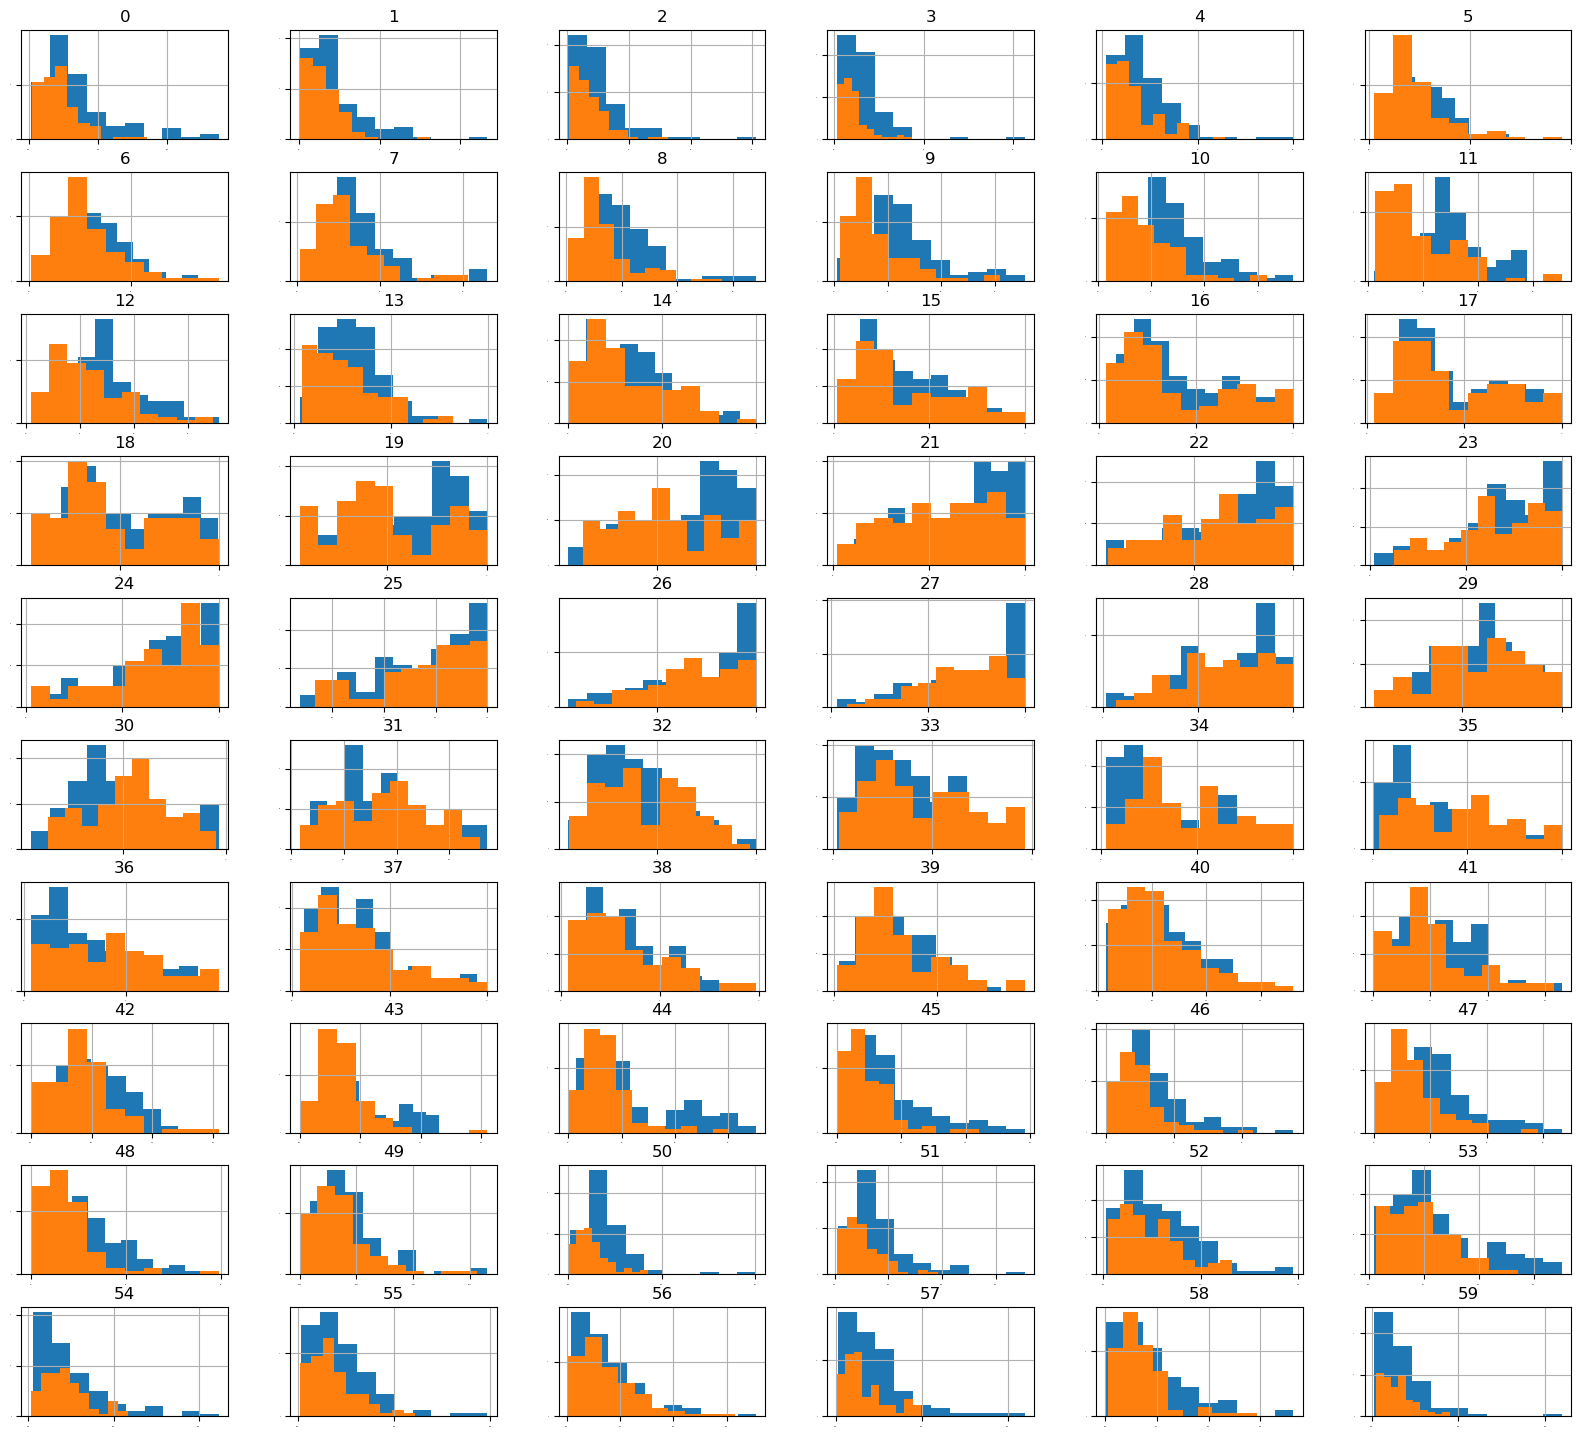

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.stats import mode
import warnings
from numpy.linalg import norm

warnings.filterwarnings("ignore")

full_path = os.getcwd()
sonar_data=pd.read_csv(full_path+"/"+"sonar_data.csv", header=None, sep=";")
sonar_data_list = sonar_data.values.tolist()

lista=[]
lista_2=[]

for index in sonar_data.index:
    if sonar_data.iloc[index][60]=="M":
        lista.append(sonar_data.iloc[index])
    elif sonar_data.iloc[index][60]=="R":
        lista_2.append(sonar_data.iloc[index])
    
df_M=pd.DataFrame(lista)
df_R=pd.DataFrame(lista_2)

length = 60
axes=df_M.hist(layout=(10,6), xlabelsize=1, ylabelsize=1, figsize=(20,18))
df_R.hist(ax=axes.ravel()[:length],layout=(8,8), xlabelsize=1, ylabelsize=1, figsize=(20,18))

### 1.2 Tratamento dos dados

<font size=4.25>

<p style='text-align: justify;'>
Os dados, uma vez que já tinha sido submetidos a uma normalização prévia, não necessitavam de um tratamento extensivo. As únicas modificações realizadas neste sentido foi a conversão dos dados de saída R e M em 0 e 1, respectivamente, bem como a separação do conjunto de dados em treinamento e teste. 
<p/>

In [2]:
sonar_data_features = sonar_data[sonar_data.columns[sonar_data.columns[0]:len(sonar_data.columns)-1]].values.tolist()

sonar_data_target = sonar_data[len(sonar_data.columns)-1].apply(lambda x: 1 if x=='R' else 0).values.tolist()

validation_size = 0.25

seed = 7

X_train, X_teste, Y_train, Y_teste = train_test_split(sonar_data_features, sonar_data_target, test_size=validation_size, random_state=seed)

X_train=np.array(X_train)
Y_train=np.array([Y_train]).T
X_teste = np.array(X_teste)
Y_teste = np.array([Y_teste]).T

### 2.0 Rede Neural - <em>Multilayer Percepton</em> | Introdução

<font size=4.25>

<p style='text-align: justify;'>
Essencialmente as redes neurais tem como parte constitutiva os neurônios. Estes, por sua vez, fundamentam-se no recebimento de sinais de entrada, $x_{i}$, i=1,...,m, que junto com sinais de polarização (bias), são ponderados pelos pesos sinápticos $w_{k}$, onde k representa o índice do neurônio e j indica o sinal de entrada ao qual peso está associado. Desta combinação linear, tem-se a geração de $v_{k}$ que quando passados por uma função de ativação, usualmente de caráter não linear, geram a saída $y_{k}$ (Equação 1).
<p/>
    
\begin{equation} 
y_{k} = Ф(v_{k}) = Ф(\sum_{j=1}^{m} w_{kj}x_{j} + w_{k0}) 
\end{equation}

    
<font size=4.25>


<p style='text-align: justify;'>
As redes MLP (Multi-Layer Percepton) caracterizam-se por possuírem n camadas intermediárias entre a entrada e saída, em que os neurônios da camada l estão totalmente conectados com os neurônios da camada l-1. A figura abaixo ilustra um exemplo rede neural MLP. 
<p/>
    
<img src=rede_neural_3.png>
     
<font size=4.25>

<p style='text-align: justify;'>
    
Semelhantemente à notação matemática do neurônio previamente exposta, os neurônios das camadas intermediárias possuirão o equacionamento expresso na Equação 2 (formulação matemática para o neurônio i da Figura acima):
<p/>  

\begin{equation} 
y_{i}^l = Ф(v_{k}) = Ф(\sum_{j=1}^{nl-1} w_{ij}^ly_{j}^{(l-1)} + w_{k0}) 
\end{equation}
    
<font size=4.25>

<p style='text-align: justify;'>
    
Onde $w_{ij}$ representa o peso sináptico da conexão que liga o j-ésimo neurônio da camada l-1 ao i-ésimo neurônio da camada l.
<p/> 
    
<font size=4.25>

<p style='text-align: justify;'>
As camadas intermediárias são especialmente importantes, pois elas irão realizar os mapeamentos não lineares da rede, tornando, portanto, a informação contida nos dados de entrada mais próximas do mapeamento que se deseja realizar.
<p/> 
    
<font size=4.25>

<p style='text-align: justify;'>   
As funções abaixo apresentam a rede MLP, do ponto de vista da geração das respostas, bem como a função de ativação utilizada nos neurônios. Neste caso, em específico, para fins de simplificação, utilizou-se como função ativação a função sigmoidal (Equação 3). 
<p/> 
    
\begin{equation} 
Ф(x) = \frac {1}  {1 + e^{-x}} 
\end{equation}

    

In [3]:
def sigmoid_function (z):
    return 1/(1+np.exp(-z))

def feed_forward (weights,bias,inputs):
    network=[]
    for i in range(len(weights)):
        if i ==0:
                linear_comb= np.dot(weights[i],inputs.T)+bias[i] 
                network.append(sigmoid_function(linear_comb))
        else:
                inputs = network
                linear_comb = np.dot(weights[i], inputs[i-1])+bias[i]
                network.append(sigmoid_function(linear_comb))
    return network

### 2.1 Rede Neural - MLP | Treinamento - <em> Backpropagation </em>

<br>

<font size=4.25>

<p style='text-align: justify;'>
O processo de treinamento consiste no ajuste dos pesos sinápticos $w_{ij}$ de sorte que os seus respectivos valores proporcionem o melhor mapeamento entre a entrada e a saída. A definição dos pesos com estes valores dá origem a um problema de otimização não linear irrestrita, onde busca-se a minimização da função custo ($J_{w}$) que basicamente expressa a diferença entre a saída gerada pela MLP ($\hat{y}(i)$) e as saídas originais ($y(i)$). Neste caso, dado que estamos tratando de uma problema de classificação entre duas classes, utilizou-se a entropria cruzada binária como função custo ($J_{w}$) - Equação 4.
<p/>
    
\begin{equation} 
J(w) = \frac {1}  {N} \sum_{n=1}^{N} \sum_{j=1}^{r} [y(i)log(\hat{y}(x(i))) + (1-y(i))log(1-\hat{y}(x(i)))]
\end{equation}

In [4]:
def binary_cross_entropy (weights, bias, X_data, Y_data):
    y_hat = feed_forward (weights, bias, X_data)
    cost_function = np.sum(-Y_data.T*(np.log(y_hat[len(y_hat)-1]))-(1-Y_data).T*np.log(1-((y_hat[len(y_hat)-1]))))
    return cost_function

<font size=4.25>

<p style='text-align: justify;'>
Tipicamente a minimização da função custo dá-se através de métodos de derivadas de primeira ordem (gradiente) por meio de um processo iterativo. Assim, com o vetor gradiente em mãos, que aponta para cima (na direção da maximização da função custo), tem-se a necessidade de apontá-lo para baixo, isto é, é necessário substrair o gradiente ($∇_{w}$) dos pesos w, conforme apresenta a Equação 5:
<p/>
             
\begin{equation} 
w_{i+1}\rightarrow w_{i} - \alpha \nabla J(w_{i})^{T}
\end{equation}

    

In [5]:
def update_weights (weights,bias,grad_weights, grad_bias, lr): 
    for i in range(len(grad_weights)):
            weights[i]-=lr*grad_weights[i]
            bias[i]-=lr*grad_bias[i]
    return weights, bias

<br>
<font size=4.25>
    
<p style='text-align: justify;'>
Conforme exposto, a definição dos pesos que minimizem a função custo passa necessariamente por determinar o gradiente da função custo em relação aos pesos sinápticos. Contudo, a partir da equação da função custo acima, nota-se que os pesos sinápticos não estão explicitamente expostos quando se contabiliza a função custo. A fim de criar a relação de depedência explicíta entre J(w) e os pesos é necessário a utiilzação da regra da cadeia. 

<p/>
    
<font size=4.25>
    
<p style='text-align: justify;'>
Em um primeiro momento, é possível observar que as saídas da última camada aparece de forma direta, com isso a derivada de J(w) com relação ao pesos dos neurônios é simples de se obter. Contudo, por outro lado, ao se observar as derivadas com respeito às demais camadas da rede não existe uma dependência direta dos pesos associados às camadas anteriores com relação à função custo J(w). Neste sentido, é necessário fazer a retropropagação (backpropagation) dos erros da função custo até o neurônio em questão , através da regra da cadeia. A Equação 6 apresenta um exemplo de uma retropropagação a fim de levantar o gradiente de pesos de um neurônio da camada intermediária imediatamente antecedente à última.    
<p/>
    
    
\begin{equation} 
\frac{\partial J(w)}{\partial w_{j}^{l}} = \frac {\partial J(w)}  {\partial \hat{y}_{out}} \frac {\partial \hat{y}_{out}}{\partial v_{out}}\frac  {\partial v_{out}} {y_{j}^{l}}  \frac {\partial y_{j}^{l}} {\partial v_{j}^{l}} \frac {\partial v_{j}^{l}} {\partial w_{j}^{l}}
\end{equation}
    
<font size=4.25>
    
<p style='text-align: justify;'>
    
Em notação vetorial, a regra da cadeia poder ser aproximada, pelos seguintes equacionamentos:
    
    
<em> Camada de Saída <em> - Equação 7:


\begin{equation} 
\frac{\partial J(w)}{\partial w_{i,j}^{(out)}} = {y_{j}^{(L)}}\delta_{i}^{(out)}
\end{equation}

onde:
    
\begin{equation} 
\delta^{(out)} = \hat y - y
\end{equation}

      
Demais camadas (intermediárias e de entrada) - Equação 9:
    
\begin{equation} 
\frac{\partial J(w)}{\partial w_{i,j}^{(l)}} = {y_{j}^{(l-1)}}\delta_{i}^{(l)}
\end{equation}
    
onde:

\begin{equation} 
\delta^{(l)} = \delta^{(l+1)}(w^{l+1}) \odot \frac {\partial y^{l}} {\partial v^{l}} = \delta^{(l+1)}(w^{l+1}) \odot [Ф(v^{l})\odot(1-Ф(v^{l}))]
\end{equation}
    
Nota-se que a derivada de $y^l$ (saída dos neurônios da camada l) é a derivada da função de ativação em relação ao seu próprio argumento $v^{l}$.

In [6]:
def der_sig_function (neuron_values):
    if len(neuron_values) == 1:
        return neuron_values*(1-neuron_values) 
    else:
        return [value*(1-value) for value in (neuron_values)]

def back_propagation (network, weights, bias,Y_converted, X_data):
    
    contador=0
    error=[]
    grad_weights=[] 
    grad_bias=[]
    
    for i in reversed(range(len(network))): 
        if i != len(network)-1 and i!=0:
            contador+=1
            sigma=np.multiply(np.dot(np.array(error[contador-1]),weights[i+1]),np.array(der_sig_function(network[i])).T)
            grad_value = np.dot(np.array(network[i-1]),sigma)
            grad_bias_value = np.array([np.sum (sigma, axis=0)])
            error.append(sigma)
            grad_weights.append(grad_value.T)
            grad_bias.append(grad_bias_value.T)
        elif (i==0):
            contador+=1
            sigma=np.multiply(np.dot(np.array(error[contador-1]),weights[i+1]),np.array(der_sig_function(network[i])).T)
            grad_value = np.dot(np.array(X_data).T,sigma)
            grad_bias_value = np.array([np.sum (sigma, axis=0)])
            grad_weights.append(grad_value.T)
            grad_bias.append(grad_bias_value.T)
        else:
            sigma_out=network[len(network)-1].T-Y_converted
            grad_weights_values = np.dot(network[len(network)-2],sigma_out)
            grad_bias_value = np.array([np.sum(sigma_out, axis=0)])
            grad_weights.append(grad_weights_values.T)
            grad_bias.append(grad_bias_value.T)
            error.append(sigma_out)

    grad_weights.reverse()
    grad_bias.reverse()
    
    return grad_weights, grad_bias

<font size=4.25>
    
<p style='text-align: justify;'>

Outro ponto importante a ser levado em conta é a forma como os pesos serão atualizados. A rigor, o vetor gradiente pode ser estimado segundo uma estimação em batelada (batch), estocástica (padrão-a-padrão) ou com base em pequenos lotes (mini-batches). 
</p>
    
<p style='text-align: justify;'>  
-<b> Batelada (batch) </b>: Neste contexto a estimativa do vetor gradiente é contabilizada levando em conta todas as amostras do conjunto de treinamento de uma vez só. Este tipo de abordagem, a depender do tamanho do conjunto de treinamento disponível, pode ocasionar um alto custo computacional inviabilizando o processo de otimização necessário à determinação dos parâmetros/pesos do modelo.    
</p>
 
<p style='text-align: justify;'>  
-<b>Estocástico (padrão-a-padrão)</b>: Diametralmente oposto à estimação via batelada, o método estocástico faz a contabilização do vetor gradiente percorrendo uma amostra do conjunto de treinamento por vez. O final da época é caracterizado quando todas as amostras do conjunto de treinamento forem percorridas.Dado que estamos lidando com somente uma amostra por vez, este tipo de estimação tende a ser mais rápido que o método em bateladas, e também permite que o processo de otimização consiga lidar com um conjunto de dados bastante numeroso. De acordo com [6], essse algortimo é muito menos regular do que o gradiente descendente em bateladas, isto é, em vez de ir descendo suavemente até o ponto mínimo da função custo, ele irá subir e descer, descendo somente na média. 
</p>   
 
<p style='text-align: justify;'>  
    -<b>Pequenos lotes (mini-batches)</b>: Caracteriza-se por ser um meio termo entre o método em batelada e o método estocástico, isto é, o vetor gradiente é estimado levando em conta um número pré-fixado entre uma amostra e o conjunto inteiro de treinamento. Segundo [6], a principal vantagem deste em relação ao estocástico é que pode-se obter um ganho de desempenho com a otimização de hardware das operações de matriz (é comum no contexto de <em>deep learning</em>).   
</p>   
     
Para este caso,  utilizou-se a estimativa em pequenos lotes (mini-batches).    

<p style='text-align: justify;'>  
A função abaixo, demonstra o processo de treinamento como um todo, incluindo o  <em> backpropagation </em> bem como a forma como os pesos foram atualizados.Salienta-se, por fim, que a inicialização dos pesos deu-se através de um distribuição normal com média 0 e desvio padrão equivalente a 1. 
</p> 

In [7]:
def MLP_fit (X_data, Y_data, num_epochs, mini_batch_size, learning_rate, 
             MLP_configuration, data_indices, cost_function=[]):   
         
    weights = [np.random.randn (y,x) for x,y in zip(MLP_configuration[:-1], MLP_configuration[1:])]
    bias = [np.random.randn (y,1) for y in MLP_configuration[1:]]
    
    for epoch in range (num_epochs):   
        
        indices = np.arange(len(data_indices)-1)
        random.shuffle(indices)
        
        for mini_batch in range (0, indices.shape[0]+mini_batch_size-1, mini_batch_size):
            
            if mini_batch > len(indices):
                
                pass
            
            else:

                batch_idx=indices[mini_batch:mini_batch+mini_batch_size]

                network = feed_forward (weights, bias, X_data[batch_idx])
                

                grad_weights, grad_bias = back_propagation(network, weights, bias,Y_data[batch_idx], X_data[batch_idx]) 
                
                weights, bias = update_weights (weights, bias, grad_weights, grad_bias, learning_rate)
                
        cost_function.append(binary_cross_entropy(weights, bias, X_data,Y_data))
               
    return weights, bias, cost_function

### 2.2 Rede Neural - MLP | Validação Cruzada

<font size=4.25>
    
<p style='text-align: justify;'>
O processo de validação cruzada deu-se através da metodologia <em> k-fold </em>. Para o problema em questão foram utilizadas 4 pastas, tendo portanto 4 composições de dados junto ao conjunto de treinamento 4 junto ao conjunto de validação. Para definir alguns hiperparâmetros importantes da rede neural, tais como número de neurônios e número de camadas intermediárias, utilizou-se como métrica do modelo a acurácia. Destaca-se que, a depender da característica do problema, a acurácia não é a melhor métrica de avaliação, neste problema, em específico, a escolha de tal métrica não afeta signifitivamente as demais métricas importantes em problemas de classificação, tais como: recall, precisão e $F_{1}$ score. Por fim, definiu-se que as amostras que apresentassem probabilidades acima de 50% seria definidas como Rocha (classe - 1), caso contrário, seria definidas como minas (classe - 0). As funcões abaixo definem, respectivamente, a validação cruzada k-fold, a previsão dos rótulos e o valor das acurácias. 
</p>
    

In [8]:
def k_fold (X_data, Y_data, num_folds):
    
    list_validation_indices =[]
    
    list_train_indices=[]

    for i in range(num_folds): 
        
        n=len(X_train)/num_folds
        training_indices = np.arange(0,len(X_train))

        if i==0:

            validation_indices=np.arange(0,n)

        else:

            validation_indices=np.arange(i*n,(i+1)*n)

        validation_indices = validation_indices.astype(int) 
        train_indices = np.delete(training_indices, validation_indices)
        
        list_validation_indices.append(validation_indices)
        
        list_train_indices.append(train_indices)

    return list_train_indices, list_validation_indices


def prev_rot (weights, bias, X_data):
    y_hat= feed_forward (weights, bias, X_data)
    final_results = y_hat[len(y_hat)-1].T

    lista_classes=[]
    
    for i in range(len(final_results)):
    
        if final_results[i]>=0.5:
        
            np.array(lista_classes.append(1))
        
        else:
        
            np.array(lista_classes.append(0))
    
    return lista_classes

def accur (lista_classes,Y_data):
    soma=0
    for i in range(len(lista_classes)):
        if lista_classes[i] == Y_data[i]:
            soma+=1
    accur=soma/len(lista_classes)    
    
    return accur

<font size=4.25>
    
<p style='text-align: justify;'>
Um dos pontos importantes quando está se elaborando uma rede neural é a definição dos deus hiperparâmetros, tais como o número de neurônios bem como o número de camadas intermediárias. A fim de defini-los estabeleceu-se a função abaixo, denominada de <em> cross validation </em>. A partir dela é possível obter um dicionário com as métricas (função custo, acurácia média junto ao conjunto de validação e ao conjunto de treinamento) correspondente ao número de neurônios e as camadas intermediárias testadas. Salienta-se que por questões de simplificação do problema, em caso de haver mais de uma camada intermediária, o número de neurônios em cada uma delas é equivalente. Conforme pode ser visto abaixo, foram utilizados os seguintes valores para os demais hiperparâmetros do modelo.
    
- Número de épocas: 100
- Tamano do mini-batch: 12
- Taxa de Aprendizdo: 0.025
</p>
    
<font size=4.25>
    
<p style='text-align: justify;'>
Outros hiperparâmetros, tal como o tipo de função de ativação já foram definidas previamente.
</p>

  

In [9]:
def MLP_arch(X_data, hidden_layers:list):

    network_layers=[]

    for i in range (len(hidden_layers)+2):

        if i ==0:

            network_layers.append(len(X_data[0]))

        elif i == len(hidden_layers)+1:

            network_layers.append(1)

        else:

            network_layers.append(hidden_layers[i-1])

    return network_layers


def cross_validation (X_train_data, Y_train_data, n_hidden_layers,num_folds=4, 
                      num_max_neuron =200, num_min_neuron =1, neuron_interval=5, num_epochs = 500, 
                      mini_batch_size = 5, learning_rate=0.025):
    
    list_train_indices, list_validation_indices = k_fold(X_train_data, Y_train_data, num_folds)
    
    dic_metrics={}; 
    
    for num_neuron in range(num_min_neuron, num_max_neuron, neuron_interval):

        metrics=[]

        cost_function=[]; acc_val=[]; acc_train=[];

        neurons = MLP_arch(X_train_data, n_hidden_layers*[num_neuron])

        for i in range (len(list_train_indices)):

            X_train_final = X_train_data[list_train_indices[i]]
            Y_train_final = Y_train_data[list_train_indices[i]]

            weights, bias, cost_function = MLP_fit(X_train_final, Y_train_final, num_epochs, mini_batch_size,
                                                   learning_rate, neurons, list_train_indices[i], cost_function)

            acc_val.append(accur(prev_rot(weights,bias,np.array(X_train_data)[list_validation_indices[i]]),
                                 np.array(Y_train_data)[list_validation_indices[i]]))

            acc_train.append(accur(prev_rot(weights,bias,X_train_final),Y_train_final))

        metrics.append(np.mean(acc_val))
        metrics.append(np.mean(acc_train))
        metrics.append(cost_function[int((len(cost_function)/len(acc_val))*(np.argmax(acc_val)+1)-(len(cost_function)/len(acc_val))):
                                                      int(((len(cost_function)/len(acc_val))-1)*(np.argmax(acc_val)+1))])
        dic_metrics [num_neuron] = metrics
                       
                       
    return dic_metrics

dic_metrics ={}

for n_hidden_layers in range (1,5):
    
    dic_metrics[n_hidden_layers] = cross_validation (X_train, Y_train, n_hidden_layers, 
                                                     num_epochs=100, mini_batch_size=12)
    

<font size=4.25>
    
<p style='text-align: justify;'>
Baseado nos resultados do processo de validação cruzada, levantou-se a evolução  da acurácia média do conjunto de treino e validação conforme o número de neurônios utilizados e o número de camadas intermediárias. Em suma, nota-se que a acurácia média possui valores maiores quando a rede neural possui 2 ou mais camadas intermediárias. Diferentemente do número de camadas intermediárias, o número de neurônios por camada não possui um padrão claro de comportamento, sendo tal característica associada à forma como os pesos da rede neural são inicializados. 
</p>
   

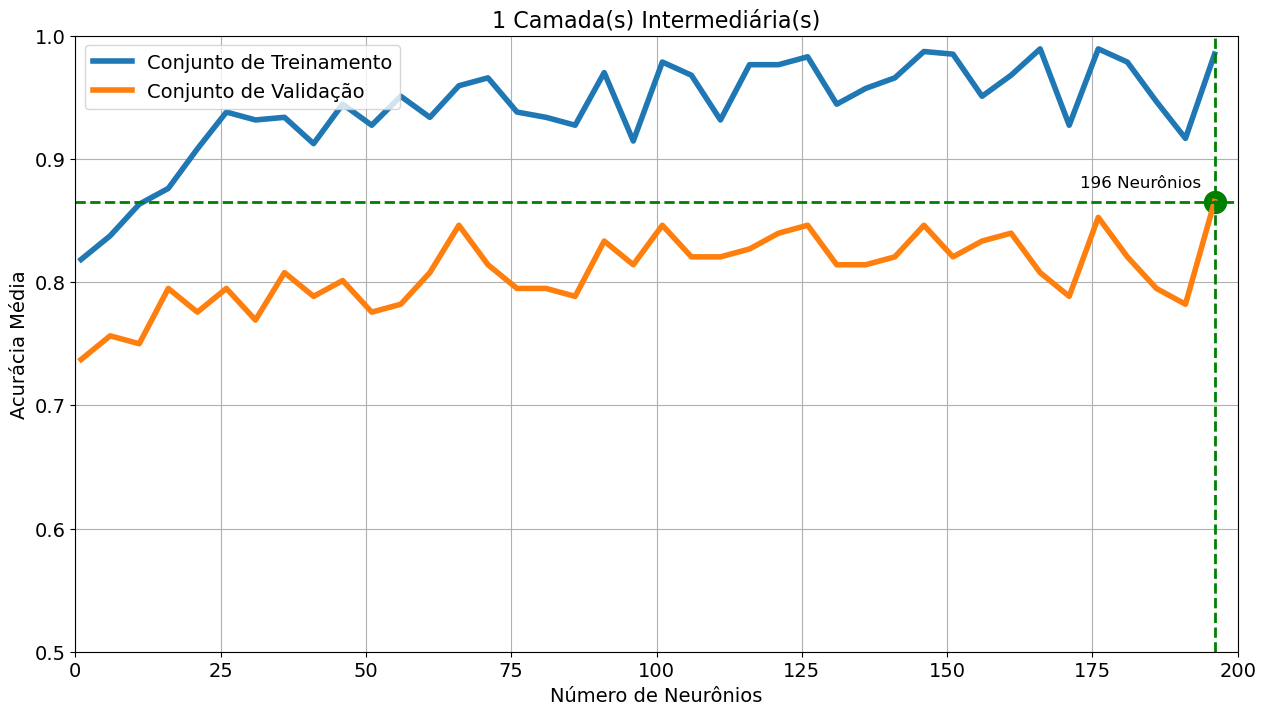

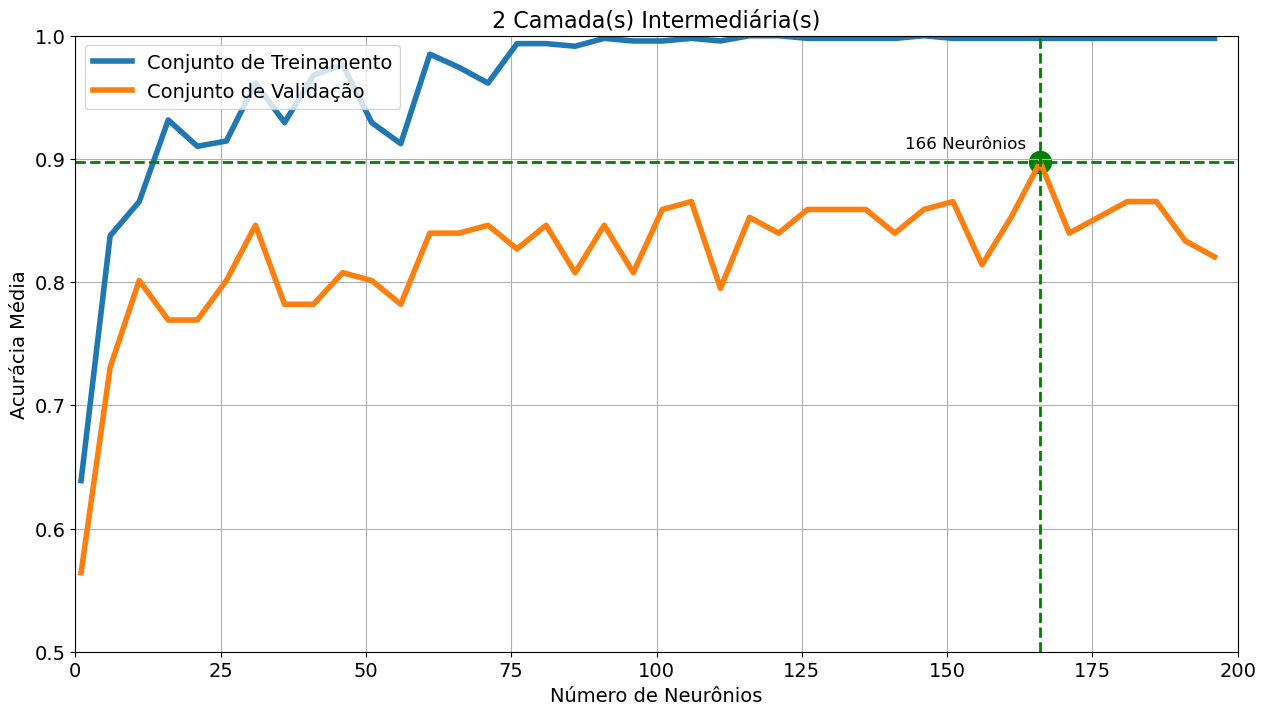

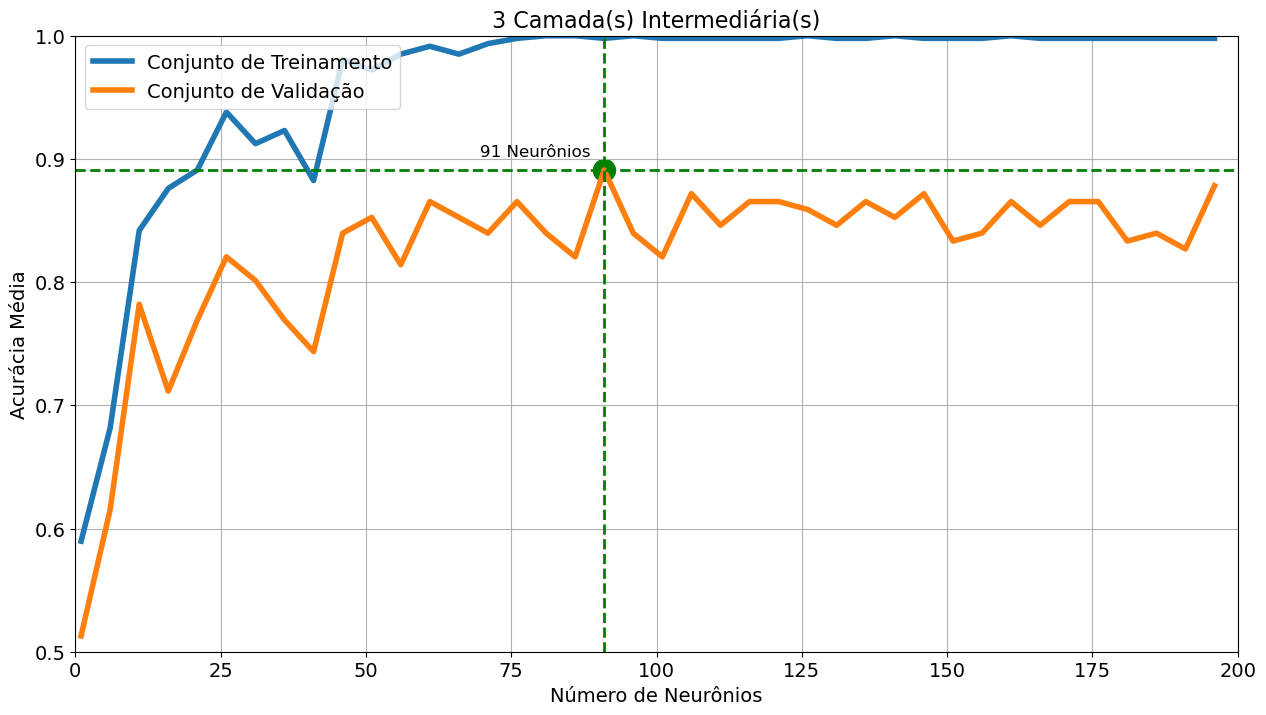

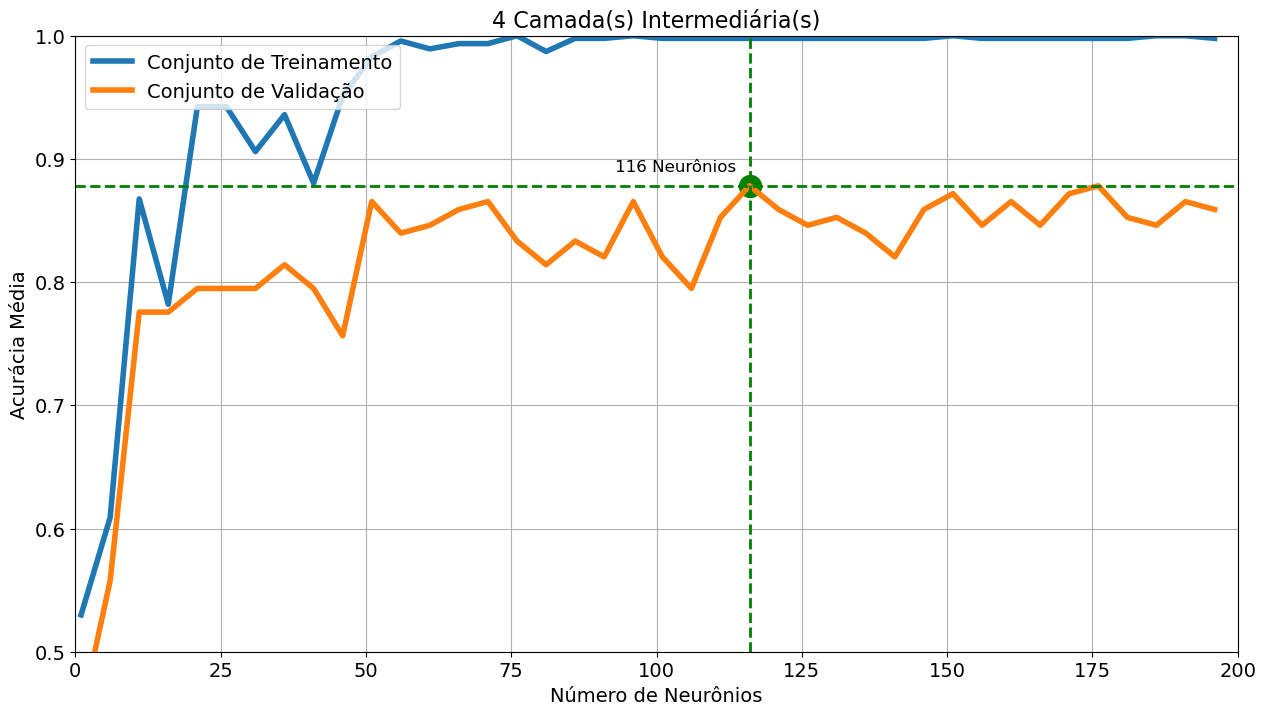

In [10]:
def CVM_plot (dic):

    for layer in dic.keys():
    
        
        list_acur_val = []
        list_acur_train =[]
        neurons=[]

        for neuron in dic[layer].keys():
        
            list_acur_val.append(dic[layer][neuron][0])
            list_acur_train.append(dic[layer][neuron][1])
            neurons.append(neuron)

        plt.figure(figsize=(15,8)) 
        
        plt.plot(neurons, list_acur_train, label = 'Conjunto de Treinamento', linewidth=4)
        plt.plot(neurons, list_acur_val, label = 'Conjunto de Validação', linewidth=4)
        plt.title(f'{layer} Camada(s) Intermediária(s)', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.axhline(max(list_acur_val), color='green', linestyle='dashed', linewidth=2)
        plt.axvline(neurons[np.argmax(list_acur_val)], color='green', linestyle='dashed', linewidth=2)
        plt.scatter(neurons[np.argmax(list_acur_val)], list_acur_val[np.argmax(list_acur_val)], 
                    s=250, color='green')
        plt.annotate('{:.0f} Neurônios'.format(neurons[np.argmax(list_acur_val)]), 
                    (neurons[np.argmax(list_acur_val)],list_acur_val[np.argmax(list_acur_val)]),
                    textcoords = 'offset points',
                        xytext=(-10,10),
                        ha='right', fontsize=12)

        plt.legend(fontsize=14, loc=2)
        plt.grid()
        plt.xlabel("Número de Neurônios", fontsize=14)
        plt.ylabel("Acurácia Média",fontsize=14)
        
        
        plt.xlim([0, (neurons[len(neurons)-1]//10)*10+10])
        plt.ylim([0.5, 1.0])

        plt.show()
        
CVM_plot(dic_metrics)

<font size=4.25>
    
<p style='text-align: justify;'>
No que diz respeito à função custo propriamente dita, foram levantadas os custos médio e mínimos por número de neurônios e camada intermediária da realização em que se obteve a maior acurácia junto ao conjunto de validação. Em outras palavras, a cada número de neurônio testado, eram levantados k (número de <em> folds </em>) valores diferentes de acurácia e os custos associados à composição de treinamento atrelado a maior acurácia era guardados para o levantamento dos custos médios e mínimos. Dito isso, a Figura abaixo apresenta a evolução do custo médio e mínimo em função do número de neurônios e camadas intermediárias. 
</p>

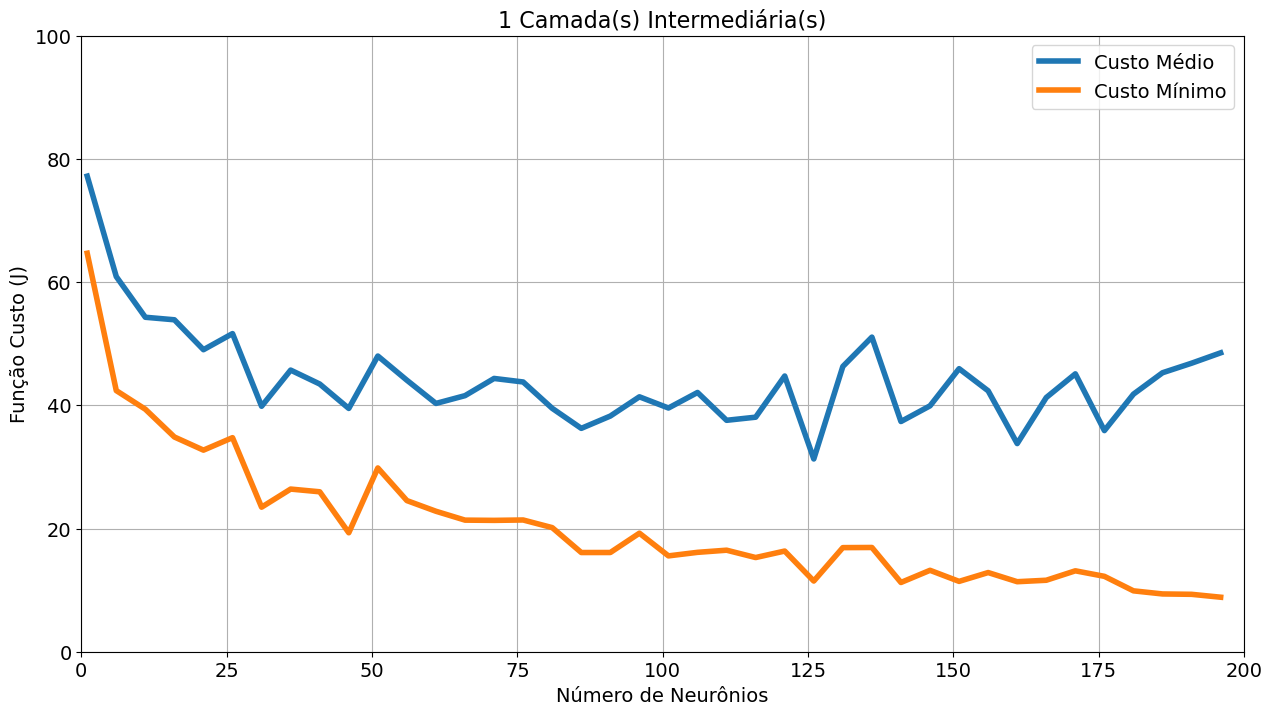

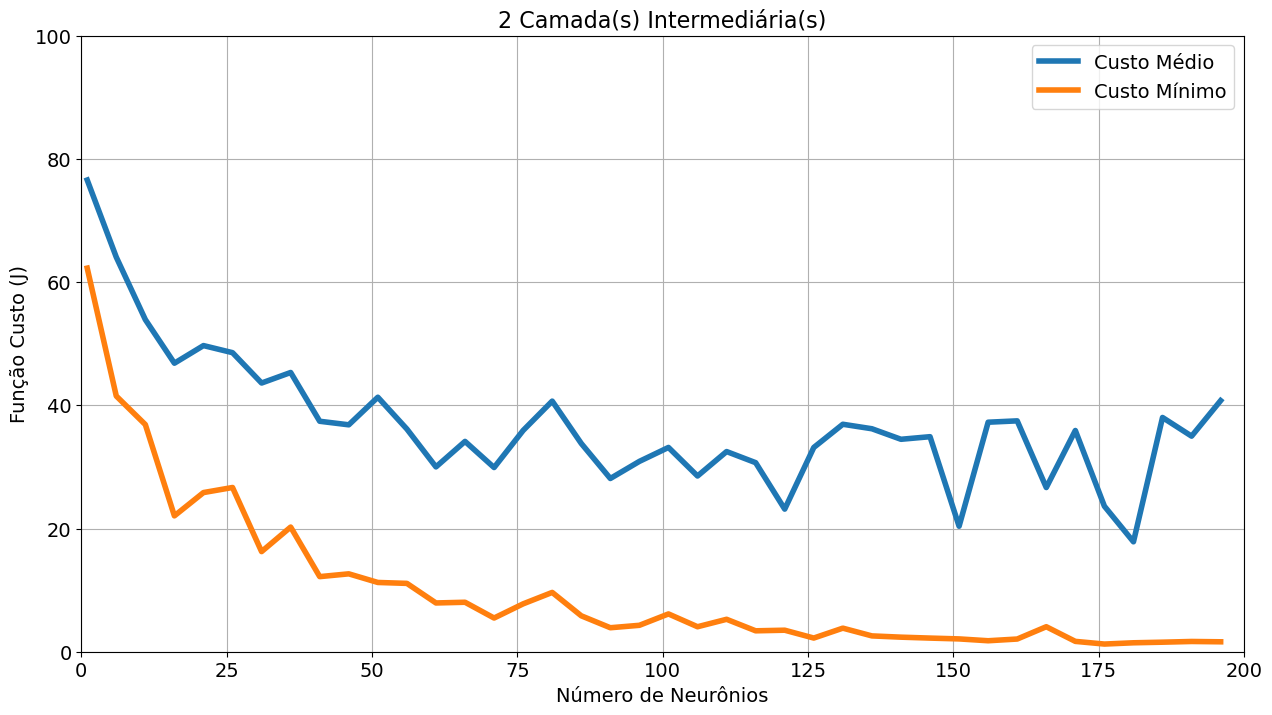

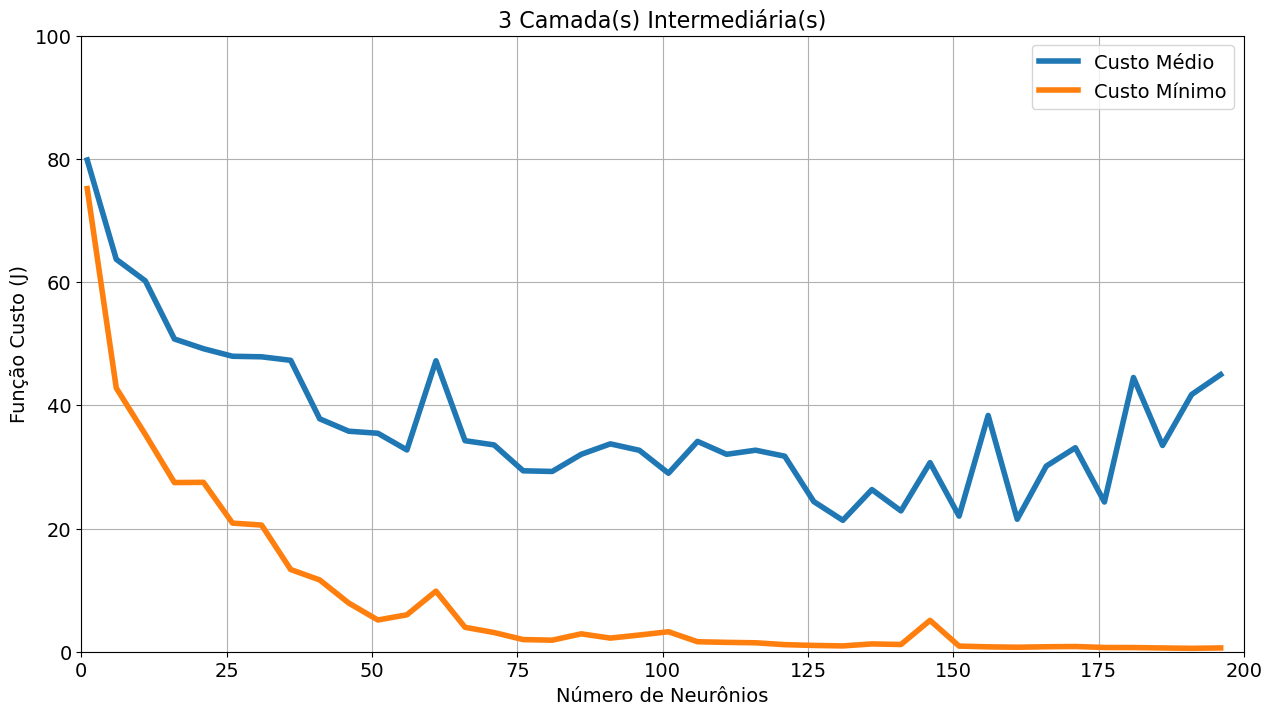

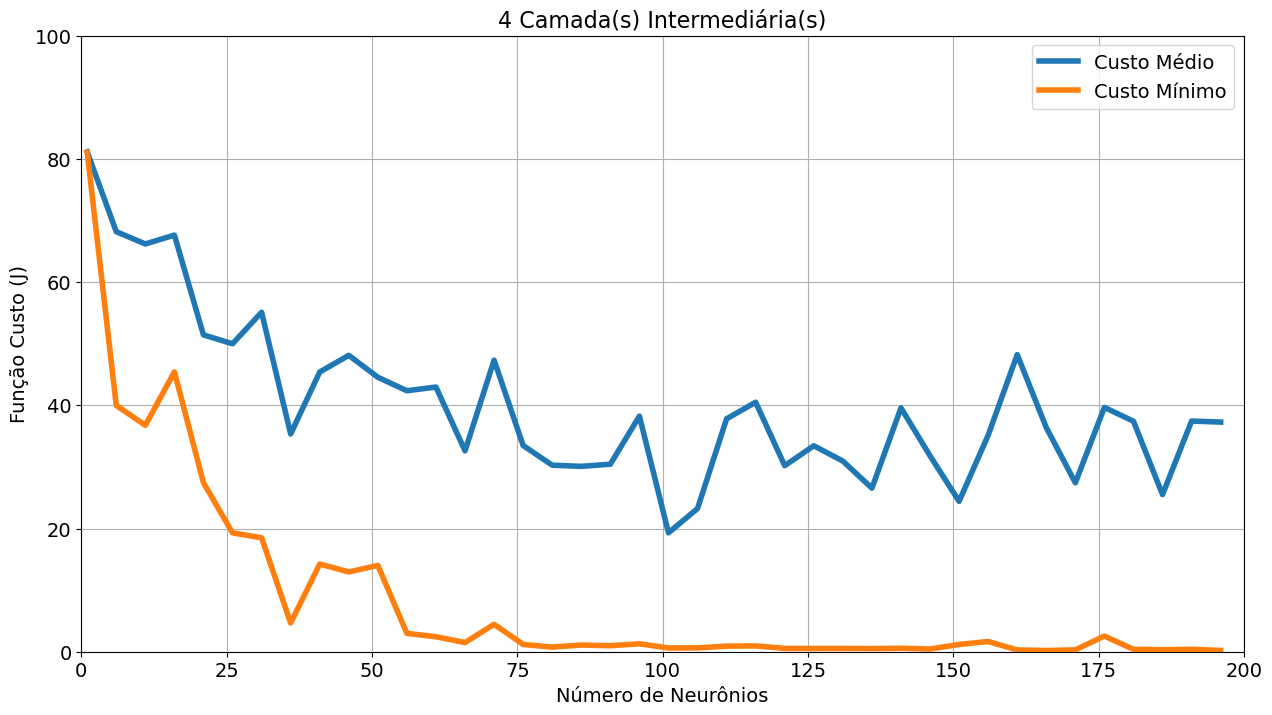

In [11]:
def J_plot (dic):

    for layer in dic.keys():
    
        list_mean_cost =[]
        list_min_cost=[]
        neurons=[]
    
        plt.figure(figsize=(15,8))

        for neuron in dic[layer].keys():

            list_mean_cost.append(np.mean(np.array(dic[layer][neuron][2])))
            list_min_cost.append(np.min(np.array(dic[layer][neuron][2])))
            neurons.append(neuron)

        plt.plot(neurons, list_mean_cost, label = 'Custo Médio', linewidth=4)
        plt.plot(neurons, list_min_cost, label= 'Custo Mínimo', linewidth=4)
        plt.title(f'{layer} Camada(s) Intermediária(s)', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
         
        plt.legend(fontsize=14)
        plt.grid()
        plt.xlabel("Número de Neurônios", fontsize=14)
        plt.ylabel("Função Custo (J)",fontsize=14)


        plt.xlim([0, (neurons[len(neurons)-1]//10)*10+10])
        plt.ylim([0, 100])

        plt.show()
        
J_plot(dic_metrics)

### 2.3 Rede Neural - MLP | Teste

<font size=4.25>
    
<p style='text-align: justify;'>
Baseado no processo de validação cruzada, foram, por fim, definidos o número de neurônios e camadas intermediárias que resultaram na maior acurácia média junto ao conjunto de validação.Conforme pode ser observado nos gráficos acima, o número de neurônios e camadas intermediárias que expressam tal condição são, respectivamente, 166 e 2.  
</p>

In [12]:
def max_value(test_dict):
    output = []
    for key in test_dict:
        max_key, max_value = max(test_dict[key].items(), key=lambda x: x[1])
        output.append([max_key, np.round(max_value[1],3),np.round(max_value[0],3)])
    
    max_value = 0
    
    for i in range(len(output)):
            
            value = output[i][2]
            
            if value > max_value:
                
                neuron = output[i][0]
                hidden_layer = i+1
                
                max_value=value
        
    return hidden_layer, neuron  


n_hidden_layers, n_neurons = max_value(dic_metrics)

<font size=4.25>
    
<p style='text-align: justify;'>
Da matriz de confusão abaixo, observa-se que embora a acurácia tenha sido utilizado como métrica de avaliação do modelo, o número de falsos positivos e falsos negativos, característicos, respectivamente, de métricas tais como precisão e sensibilidade (<em>recall</em>) é baixo. Dito isso, a Figura abaixo apresenta a acurácia,sensibilidade,precisão e $F_{1}$ score junto ao conjunto de teste.
</p>

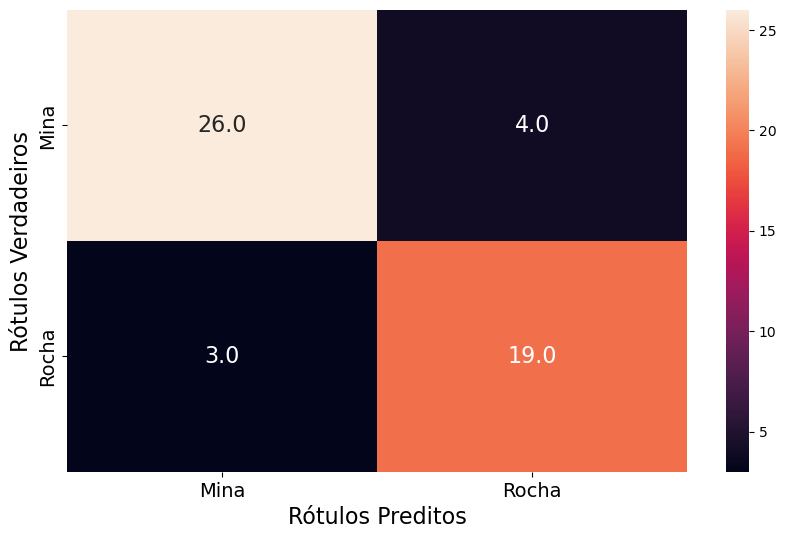

In [14]:
final_MLP_config = MLP_arch(X_train, n_hidden_layers*[n_neurons])
num_epochs = 100
mini_batch_size =12

train_indices = [i for i in range(len(X_train))]

learning_rate=0.025

weights, bias, cost_function = MLP_fit(X_train, Y_train, num_epochs, mini_batch_size,learning_rate,
                                                   final_MLP_config, train_indices, cost_function=[])

def gera_confusion_matrix(Y_pred, Y_teste):

    fig, ax = plt.subplots(figsize=(10, 6))
    cf_matrix = confusion_matrix(Y_teste,Y_pred)
    cf_matrix_fig=sns.heatmap(cf_matrix, annot=True,annot_kws={"size": 16}, fmt='.1f', ax=ax)
    ax.set_xlabel('Rótulos Preditos', fontsize=16);ax.set_ylabel('Rótulos Verdadeiros', fontsize=16);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom , top)
    ax.xaxis.set_ticklabels(['Mina', 'Rocha'], fontsize=14); ax.yaxis.set_ticklabels(['Mina', 'Rocha'], fontsize=14);

predictions_MLP = prev_rot(weights, bias, X_teste)
    
gera_confusion_matrix(predictions_MLP, Y_teste)

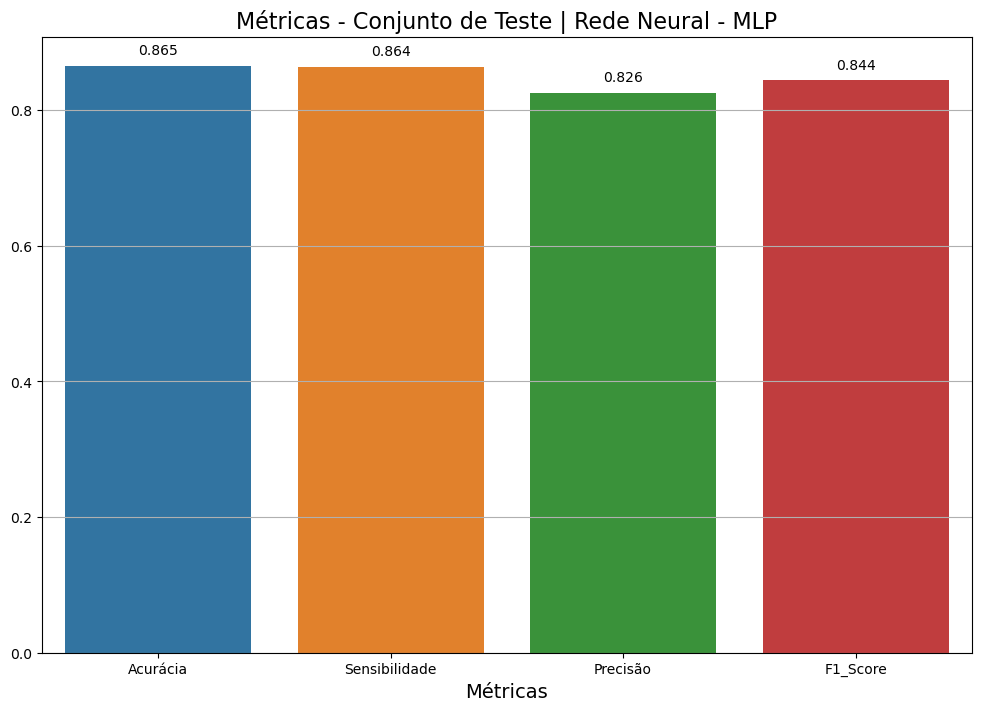

In [77]:
def plot_metrics_test (Y_pred, Y_teste, nome_modelo='Rede Neural - MLP'):

    metrics_list = ['Acurácia', 'Sensibilidade', 'Precisão', 'F1_Score']

    metrics_values=[]

    for metric in [accuracy_score, recall_score, precision_score, f1_score]:

        metrics_values.append(np.round(metric(Y_teste, Y_pred),3))

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.grid()
    barchart = sns.barplot(x=metrics_list, y=metrics_values, ax=ax)

    plt.xlabel('Métricas', fontsize=14)
    plt.title (f'Métricas - Conjunto de Teste | {nome_modelo}', fontsize=16)
    barchart.bar_label(ax.containers[0], label_type='edge', padding=6)
    
    
    
plot_metrics_test (predictions_MLP, Y_teste)

###  3.0 Máquinas de Vetores Suporte | Introdução


<font size=4.25>
    
<p style='text-align: justify;'>
Para esta técnica de aprendizado de máquina, utilizou-se a biblioteca <em> Scikit Learn </em>. Contudo, antes de imergimos no código propriamente dito, vamos analisar do ponto de vista matemático como funciona esta técnica de aprendizado de máquina. 
</p>

###  3.1 Máquinas de Vetores Suporte | Modelagem Matemática 

<font size=4.25>
      
<p style='text-align: justify;'>
Durante a fase de elaboração de um modelo de aprendizado de máquina, temos que levar em conta o erro de generalização, ou seja, o erro ocasionado pela técnica de aprendizado de máquina quando exposta a dados que não foram vistos durante o treinamento. Ao se considerar que a estrutura de classificação é linear, isto é, que o classificador dá origem a  um plano ou hiperplano em um caso multidimensional, é possível mostrar que a qualidade de generalização está associada à ideia de margem [5]. Portanto, a maximização da margem está diretamente atrelada a uma melhor generalização. A margem, por sua vez, é formalmente definida como a distância perpendicular entre a fronteira de decisão e os dados mais próximos a ela [5]. Do ponto de vista matemático, se os dados forem linearmente separáveis, ter-se-á a seguinte condição para para algum valor de w (vetor de parâmetros ou pesos) - Equação 11:
</p>
    
\\begin{equation}
    w^{t}x_{i} + b \geq 1,  \text{se } di = 1  \\
    w^{t}x_{i} + b \leq-1,  \text{se } di = -1
\end{equation}
    
Nota-se que a condição acima pode ser escrita da seguinte maneira - Equação 12:
    
\begin{equation} 
d_{i}(w^{t}x_{i} + b) \geq 1, i = 1, ... , N 
\end{equation}
    

<font size=4.25>
<p style='text-align: justify;'>
A fim de atender as condições matemática previamente escritas devemos encontar o hiperplano que resulte na máxima margem. Para tal, é necessário considerar os dados limítrofes de cada classe, isto é, os menores dados projetados da classe positiva (+1) e os maiores dados projetados da classe negativa (-1) e, a partir deles, maximizar a distância entre eles. Ao maximizar tal distância estaremos, necessariamente, maximizando a margem de separação entre classes. A distância projetada pode ser expressa pela Equação 13:
</p>    
    
\begin{equation} 
\rho (w,b) = min_{(x:d=+1)} \frac {w^{t}x} {\|w\|} - max_{(x:d=-1)} \frac {w^{t}x} {\|w\|} 
\end{equation}

<font size=4.25>
<p style='text-align: justify;'>
Nota-se da Equação X que o valor mínimo da classe positiva e o valor máximo da classe negativa serão as suas respectivas condições limítrofes, isto é, $w^{t}x + b = 1$ e $w^{t}x + b = -1$. Assim sendo, $\rho$, no ponto ótimo ($w_{o}$, $b_{o}$)  terá a configuração expressa na Equação 14:
</p> 
    
\begin{equation} 
\rho (w_{o},b_{o}) = \frac {2} {\|w_{o}\|}
\end{equation}   
    
A Figura abaixo apresenta o que foi previamente descrito.
    
<img src=SVM_graficos.png>
   
<font size=4.25>
<p style='text-align: justify;'>
Da Equação 14 nota-se que a maximização da margem ($\rho$) passa diretamente pela minimização da norma do vetor de parâmetros (pesos). Baseado nisto, podemos formular o classificador de máxima margem do seguinte modo - Equações 15 e 16:
</p>
   
\begin{equation}
min_{w,b}  \sigma =  \|w\|^{2} = w^{T}w   \\
\end{equation}
\begin{equation}
s.a: d_{i}(w^{t}x_{i} + b) \geq 1,  i = 1, ... , N
\end{equation}

<font size=4.25>
<p style='text-align: justify;'>
A resolução do problema deste problema otimização - que resultará no classificador de máxima margem - é feita utilizada multiplicadores lagrangianos ($\lambda_{i}$). De forma sucinta, os pesos/parâmetros ótimos são definidios pela Equação 17:
</p>  

\begin{equation} 
w_{o} = \sum_{i=1}^{N} \lambda_{i}d_{i}x_{i} 
\end{equation} 
 
<font size=4.25>
<p style='text-align: justify;'>
onde:
</p> 
<font size=4.25>
<p style='text-align: center;'>
<br> $\lambda_{i}$ - multiplicador langragiano i (referente à amostra i do conjunto de dados); <br>
$d_{i}$ - classe referente à amostra i <br>
$x_{i}$ - features referente à amostra i <br>
</p> 

<br>
    
<font size=4.25>
<p style='text-align: justify;'>
Da Equação 17 acima, nota-se que as amostras que exercerão influência sobre a determinação dos parâmetros - isto é, que resultarão na máxima margem - são aqueles que possuem os seus respectivos multiplicadores lagrangianos não nulos. A estas amostras dá-se o nome de vetores suporte. Interessantemente, a ideia previamente exposta associada à definição da máxima margem associada aos pontos limítrofes está em conformidade com a solução encontrada através do problema de otimização. 
</p> 

<br>
<font size=4.25>
<p style='text-align: justify;'>
No que diz respeito à definição do parâmetro de bias ($b_{i}$), isto é feito realizando uma média entre os vetores suporte [5], conforme apresenta a Equação 18:
</p>

\begin{equation} 
b_{i} = \frac{1} {N_{s}}\sum_{j \in SV} d_{j}-w_{o}^{t}x_{i}
\end{equation} 
<font size=4.25>
<p style='text-align: justify;'>
onde:
</p> 
<font size=4.25>
<p style='text-align: center;'>
    <br> <em> SV </em> - conjunto de vetores suporte; <br>
$N_{s}$ - quantidade total de vetores <br>
</p> 

###  3.2 Máquinas de Vetores Suporte | Margem Suave

<font size=4.25>
<p style='text-align: justify;'>
No racíocinio previamente exposto tem-se como premissa que os dados são linearmente separáveis. Contudo, os dados, em sua grande maioria inclusive o conjunto de dados avaliados neste trabalho, não partem dessa premissa. Uma forma de contornar essa incogruência de premissas é, ao manter a estruturar de separabilidade linear, tolerar violações da hipótese de separabilidade [5]. 
</p>

    
<font size=4.25>
<p style='text-align: justify;'>
Esta tolerância pode ser quantificada através da introdução de um conjunto de variáveis não negativas, denominada variáveis de relaxação ($\epsilon_{i}$). Desta forma, podemos reescrever a Equação 12 da seguinte maneira (Equação 19):
</p>
    
\begin{equation} 
d_{i}(w^{t}x_{i} + b) \geq 1 - \epsilon_{i}, i = 1, ... , N 
\end{equation}
    
<font size=4.25>
<p style='text-align: justify;'>
Nesta nova configuração (Equação 19), estamos considerado uma condição de separabildiade linear com certa tolerância. 
</p>
 
<font size=4.25>
<p style='text-align: justify;'>
A introdução das  variáveis de relaxação ao problema de otimização do classificador de máxima margem é feita através de um termo de penalização junto à função custo a ser minimizada (Equação 20). Ao fazê-lo estaremos também buscando minimizar o nível exigido de tolerância. 
</p>  
    
\begin{equation}
min_{w,b}  \sigma = w^{T}w  + C\sum_{k=1}^{N} \epsilon_{k}^{2} \\
\end{equation}
\begin{equation}
s.a: d_{i}(w^{t}x_{i} + b) \geq 1 - \epsilon_{i},  i = 1, ... , N
\end{equation}
 
Neste contexto, C torna-se um hiperparâmetro do modelo que atuará como uma espécie de trade-off entre as minimizações da norma das variáveis de tolerância e a norma do vetor de parâmetros. 
    
A Figura a seguir ilustra casos das variáveis de relaxação em uma SVM com margem suave. 
    
    
<img src=SVM_Margem_Suave.png>

###  3.3 Máquinas de Vetores Suporte | Funções Kernel

<font size=4.25>
<p style='text-align: justify;'>
Além das variáveis de relaxação, uma outra forma aproximar formular o problema de SVM, originalmente proposto seguindo condições de separabilidade linear, é através de funções de kernel. Esta ideia parte da premissa em que é possível produzir um mapeamento de modo a transformar um problema não linear em um problema linear. Este mapeamento, por sua vez, consiste em mapear os dados $x_{i}$ em um espaço de dimensão maior, isto é $\phi: \Re^{n} \rightarrow \Re^{m}$, onde m>n. Deste mapeamento, nota-se que ,ao introduzir os dados em um espaço de dimensão maior, os dados tendem ser mais simples de separá-los [5]. Em outras palavras, diz-se que o problema será tratado como um problema linear no espaço de características, conforme ilustra a Figura abaixo [5]. Dito isso, é possível tratar o problema em questão com as formulações previamente expostas no espaço de características.
</p>

    
<img src=função_kernel.png>
    
<font size=4.25>
<p style='text-align: justify;'>
Ao se observar a forma como a saída é gerada a partir de uma modelagem de SVM, nota-se que ela é diretamente proporcional ao produto escalar dos dados no espaço de característica (Equação 22). Neste contexto, é que finalmente surge as funções de kernel: estas têm a propriedades de determinar o produto escalar entre os dados no espaço de características sem que se determine explicitamente o mapeamento [5]. Em outras palavras, ao utilizá-las estaremos simultaneamente realizando o mapeamento e gerando o produto escalar entre os dados. 
</p>

\begin{equation} 
\hat{y} = \sum_{i=1}^{N} \lambda_{i}d_{i}{\phi}^{T}(x_{i}){\phi}(x_{j})+b = \sum_{i=1}^{N} \lambda_{i}d_{i}K(x_{i},x_{j})+b 
\end{equation} 
  
Neste projeto, foram utilizadas as seguintes funções kernel:
    
- **Linear**: $K$($x_{i},x_{j}$) = $x_{i}x_{j}$;
    
 
- **Polinomial**: $K$($x_{i},x_{j}$) = $(\gamma(x_{i}x_{j}) + 1)^d$, onde d é o grau do polinômio - sendo, portanto, um hiperparâmetro do modelo; 
    
    
- **Função de Base Radial (RBF)**: $K$($x_{i},x_{j}$) = $exp(-\gamma ||x_{i}-x_{j}||^{2})$ onde $\gamma$ é uma constante positiva, sendo também um hiperparâmetro do modelo

###  3.4 Máquinas de Vetores Suporte | Validação Cruzada

<font size=4.25>
<p style='text-align: justify;'>
Com a fundamentação por trás das Máquinas de Vetores Suporte (SVM) explicitada, o próximo passo é a definição dos hiperparâmetros necessários à modelagem do SVM. Para tal, é necesário lançar mão de um processo de validação cruzada através do método k-fold. Os hiperparâmetros avaliados foram os seguintes:
</p>
    
- Módulo do parâmetro C;
- Módulo de $\gamma$ (necessário às funções kernel RBF e Polinomial);
- Módulo do polinômio d (necessário à definição da função kernel Polinomial);
- Tipo de função kernal utilizada, conforme exposto anteriormente;


In [16]:
num_folds = 4
validation_size = 0.25
seed = 7
scoring = 'accuracy'


kf = KFold(n_splits=num_folds)
c_values=[0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.3, 1.5, 1.7, 2.0, 5.0, 10, 20,30,50]
kernel_values = ['linear', 'poly', 'rbf']
degree_values =[i for i in range(2,9)]
gamma_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.3, 1.5, 1.7, 2.0, 3.0, 5.0]
param_grid=dict(C=c_values, kernel=kernel_values, degree = degree_values, gamma=gamma_values)
model = SVC()
grid =GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kf)
grid_result = grid.fit(X_train, Y_train)

<font size=4.25>
<p style='text-align: justify;'>
As Figuras abaixo apresentam a evolução da acurácia média junto ao conjunto de validação para as diferentes funções kernel. Neste caso, o termo 'evolução' baseia-se na variação da acurácia média a partir do diferentes valores do hiperparâmetro C. Para as funções kernel RBF e polinomial foram também avaliados, respectivamente, a variação dos valores de $\gamma$ e de d (grau do polinômio). 
</p>
    

Text(0.5, 1.0, 'Kernel Linear')

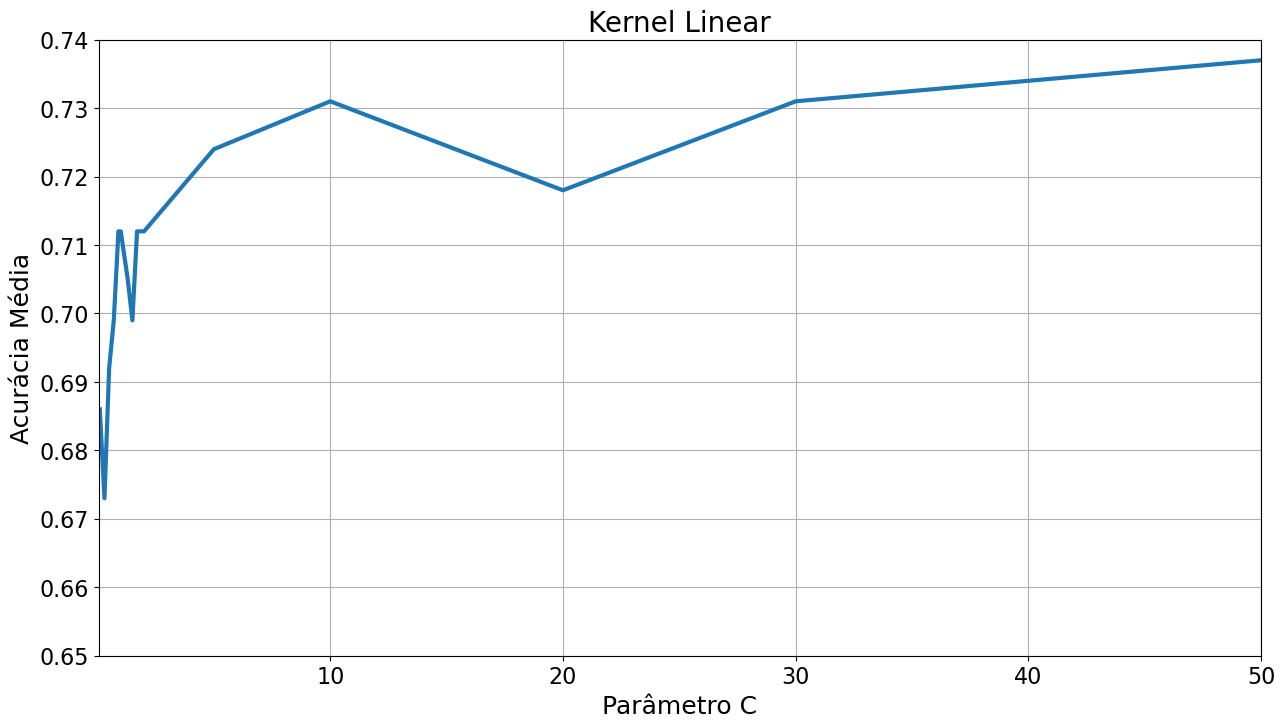

In [17]:
acc_mean_score_linear=[]

plt.figure(figsize=(15,8))

for i in range (len(grid_result.cv_results_['params'])):
    
        if  grid_result.cv_results_['params'][i]['kernel'] == 'linear':
            
            acc_mean_score_linear.append(np.round(grid_result.cv_results_['mean_test_score'][i],3))
            
acc_mean_score_linear = [np.mean(acc_mean_score_linear[i:i+len(degree_values)*len(gamma_values)]) 
                                for i in range(0, len(acc_mean_score_linear),
                                               len(degree_values)*len(gamma_values))]

plt.plot(c_values, acc_mean_score_linear, linewidth=3)

plt.xlabel("Parâmetro C", fontsize=18)
plt.ylabel("Acurácia Média",fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.xlim([0.05, max(c_values)])
plt.ylim([0.65, 0.74])

plt.grid(True)

plt.title('Kernel Linear', fontsize=20)

Text(0.5, 1.0, 'Kernel RBF')

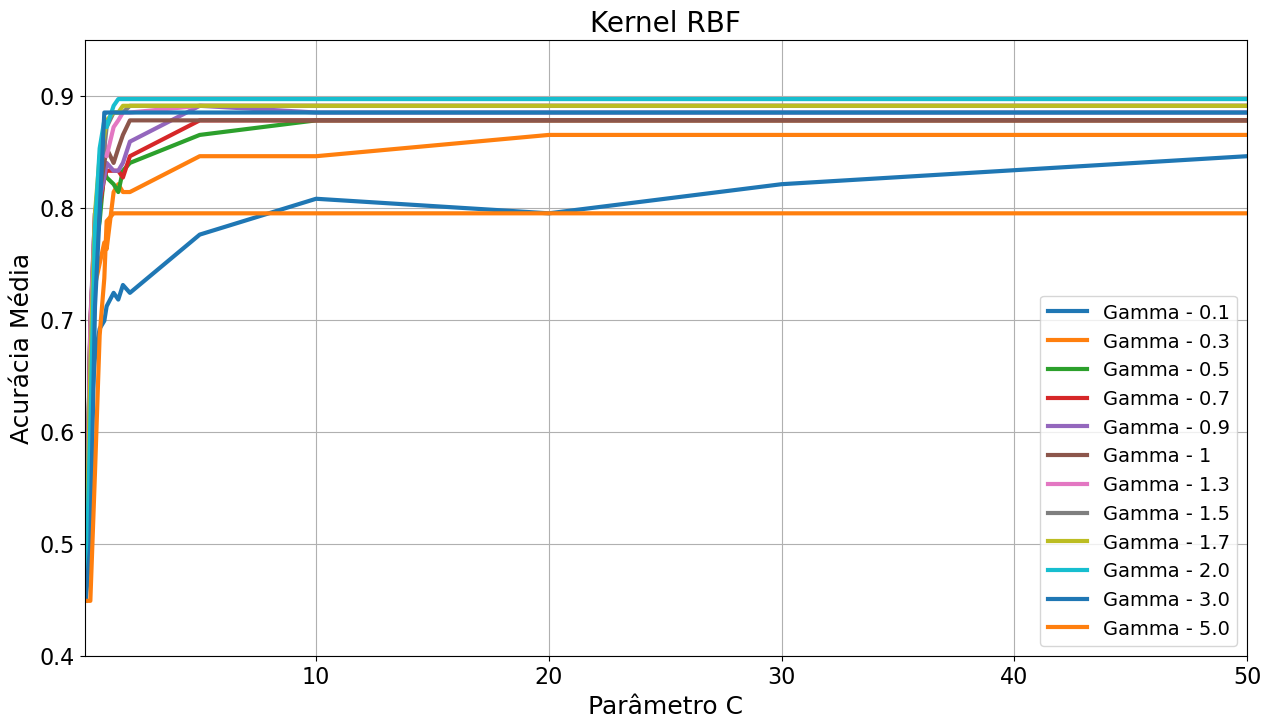

In [18]:
plt.figure(figsize=(15,8))

for gamma in gamma_values:

            gamma_mean_score = []

            for j in range (len(grid_result.cv_results_['params'])):

                if (grid_result.cv_results_['params'][j]['gamma'] == gamma and 
                grid_result.cv_results_['params'][j]['kernel'] == 'rbf'):  
                    
                    gamma_mean_score.append(np.round(grid_result.cv_results_['mean_test_score'][j],3))
                    
            gamma_mean_score = [np.mean(gamma_mean_score[i:i+len(degree_values)]) 
                                for i in range(0, len(gamma_mean_score),len(degree_values))]
    
            plt.plot(c_values, gamma_mean_score, label=f'Gamma - {gamma}', linewidth=3)

            plt.xlabel("Parâmetro C", fontsize=18)
            plt.ylabel("Acurácia Média",fontsize=18)

            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)


            plt.xlim([0.05, max(c_values)])
            plt.ylim([0.4, 0.95])
            
            #ax[row, col].set_title(title, fontsize=12)

            plt.legend(fontsize=14, loc=4)
            
            plt.grid(True)

            #ax[row,col].grid(True)
            
plt.title('Kernel RBF', fontsize=20)

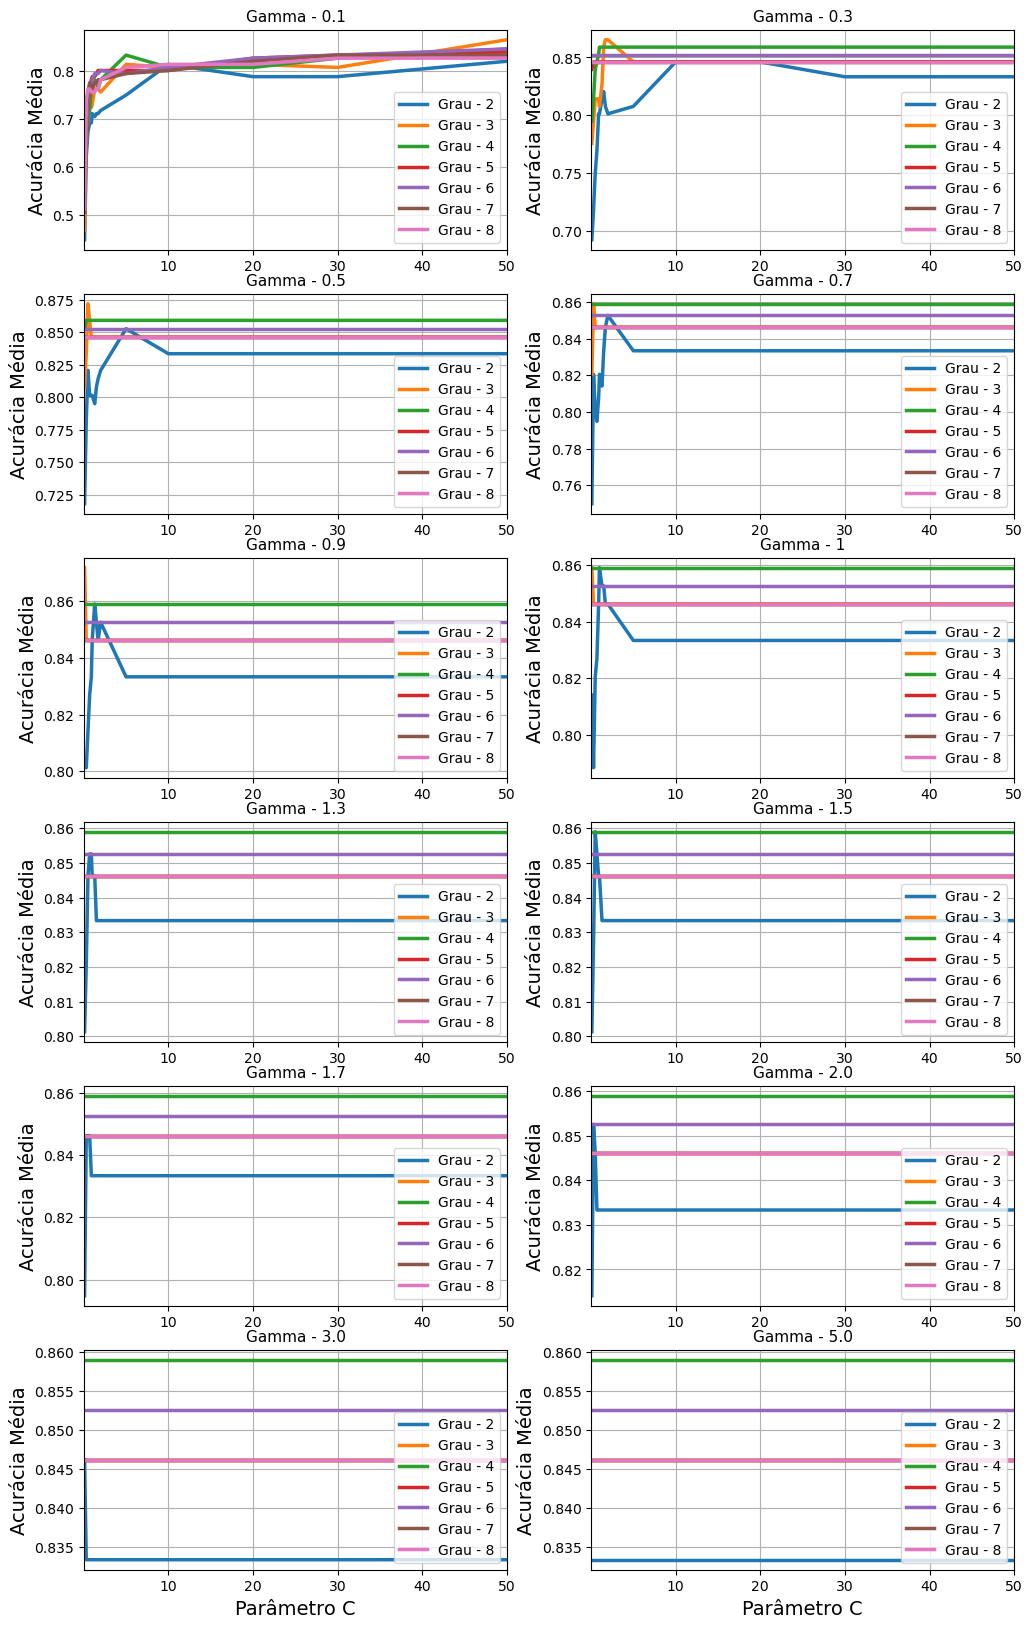

In [19]:
figure, ax = plt.subplots(int(len(gamma_values)/2),2, figsize=(12,20))

for i in range(len(gamma_values)): 
    
    if i%2 ==1:
        
        row, col = int((i-1)/2), 1
        
    else:
        
        row, col = int(i/2),0  
        
     
    if i == len(gamma_values)-1 or i == len(gamma_values)-2:  
    
        ax[row,col].set_xlabel('Parâmetro C', fontsize=14);
    
    
    for degree in degree_values:

            degree_mean_score = []

            for j in range (len(grid_result.cv_results_['params'])):

                if (grid_result.cv_results_['params'][j]['degree'] == degree and 
                grid_result.cv_results_['params'][j]['kernel'] == 'poly') and grid_result.cv_results_['params'][j]['gamma'] == gamma_values[i]:

                    degree_mean_score.append(grid_result.cv_results_['mean_test_score'][j])

            ax[row,col].plot(c_values, degree_mean_score, label=f'Grau - {degree}', linewidth=2.5)


            ax[row,col].set_ylabel("Acurácia Média",fontsize=14)

            ax[row,col].set_xlim([0.05, max(c_values)])
            
            
            title = f'Gamma - {gamma_values[i]}'
            ax[row, col].set_title(title, fontsize=11)

            ax[row,col].legend(fontsize=10, loc=4)

            ax[row,col].grid(True)


<font size=4.25>
<p style='text-align: justify;'>
Após o processo de validação cruzada e da análise dos gráficos acima, foram determinados os hiperparâmetros que resultaram na melhor acurácia média junto ao conjunto de validação. São eles:
</p>

- Kernel: RBF
- Parâmetro C: 1.5
- $\gamma$: 2
    
<font size=4.25>
<p style='text-align: justify;'>
A Figura abaixo apresenta um exemplo das regiões de decisão definidas pelo SVM junto com os dados que compõem o conjunto de treinamento. 
</p>
    
    

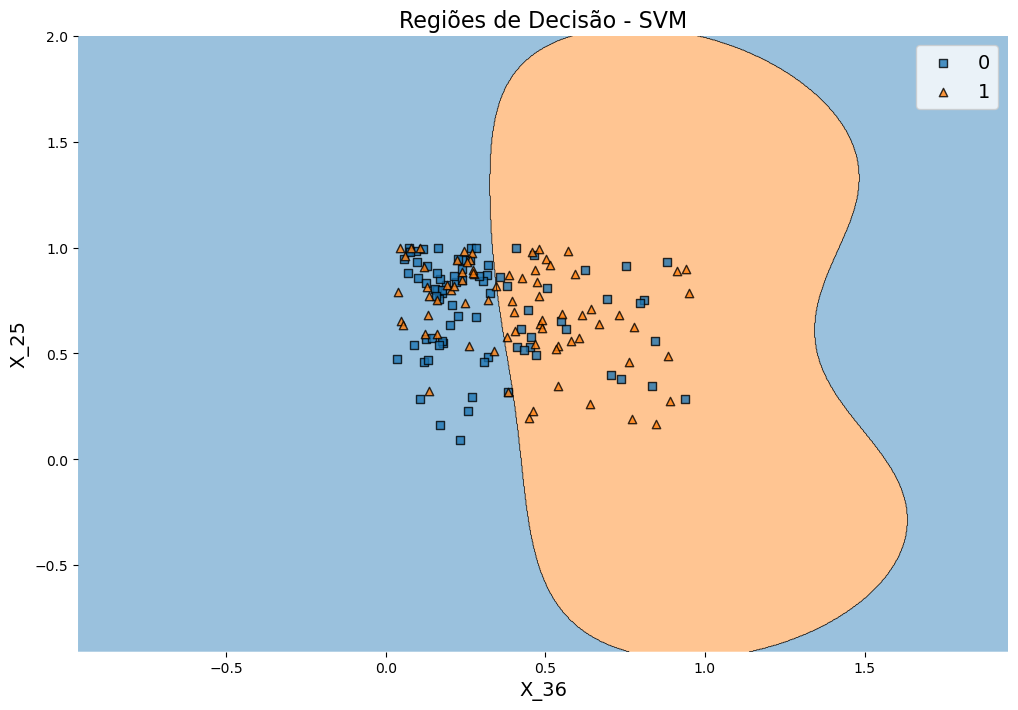

In [20]:
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(12,8))

column_A =36

column_B =25

X = X_train[:,[column_A, column_B]]
y = Y_train

lista = np.array([y[i][0] for i in range (len(y))])

svm = SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'], 
               gamma = grid_result.best_params_['gamma'])
svm.fit(X, y)

plot_decision_regions(X, lista, clf=svm, legend=2)

plt.xlabel(f'X_{column_A}', fontsize=14)
plt.ylabel(f'X_{column_B}', fontsize=14)
plt.title('Regiões de Decisão - SVM', fontsize=16)
plt.legend(fontsize=14)
plt.show()



###  3.5 Máquinas de Vetores Suporte | Teste

<font size=4.25>
<p style='text-align: justify;'>
Com os hiperparâmetros definidos no processo de validação cruzada, os vetores suporte foram definidos junto ao conjunto de treinamento. Semelhantemente aos resultados obtidos com a rede neural (MLP), os resultados obtidos pela SVM indicaram o número baixo de falsos negativos e falsos positivos relativos à sensibilidade e precisão, respectivamente, foram baixos. Observa-se que, embora o número de falsos positivos e negativos seja baixo, os valores de precisão, sensibilidade, acurácia e F1-Score são menores que aqueles obtidos pela rede neural. 
</p>
    
  

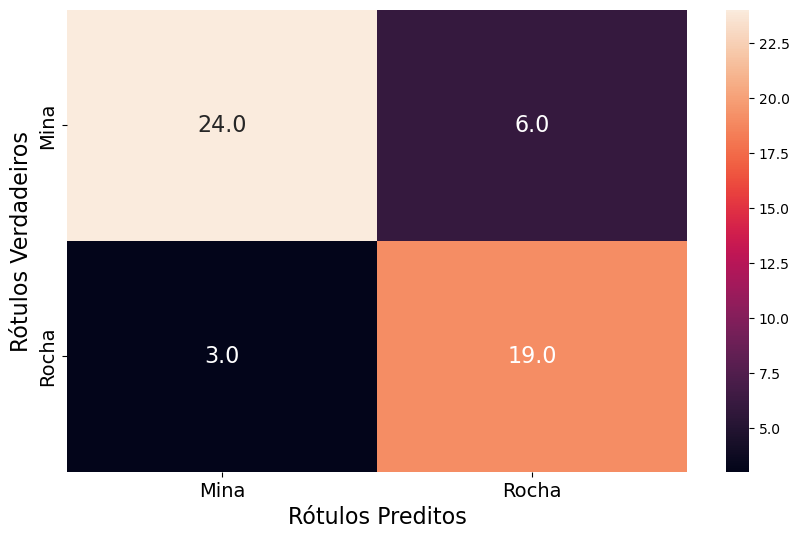

In [21]:
best_model=SVC(kernel=grid_result.best_params_['kernel'], C=grid_result.best_params_['C'], 
               gamma = grid_result.best_params_['gamma'])
best_model.fit(X_train, Y_train)
predictions_SVM = best_model.predict(X_teste) 

gera_confusion_matrix(predictions_SVM, Y_teste)

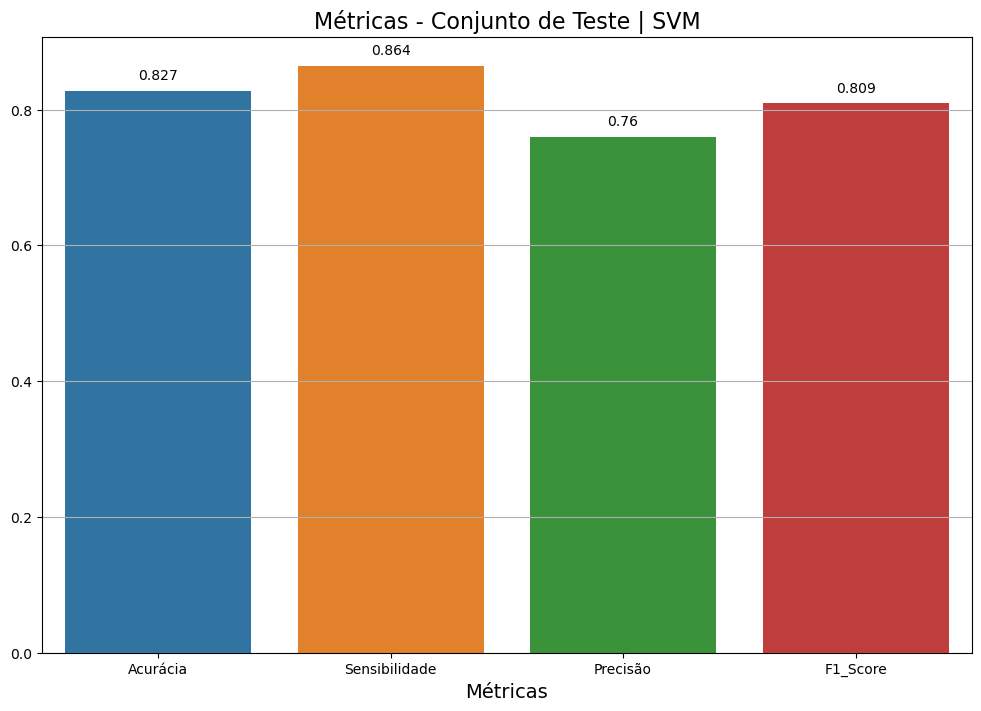

In [78]:
plot_metrics_test (predictions_SVM, Y_teste, nome_modelo = 'SVM')

###  4.0 K vizinhos mais próximos (KNN) | Introdução

<font size=4.25>
    
<p style='text-align: justify;'>
O último modelo escolhido a ser avaliado foi o K vizinhos mais próximos. Para tal e semelhantemente ao modelo de MLP, a modelagem matemática foi feita a partir do zero (<em>from scratch</em>). 
</p>

###  4.1 K-vizinhos mais próximos (KNN) | Modelagem Matemática e Determinação do Valor K

<font size=4.25>
    
<p style='text-align: justify;'>
A modelagem do tipo KNN é do tipo não paramétrica e, portanto, não há um modelo a ser ajustado tampouco é necessário fazer alguma suposição dos dados de entrada. A modelagem KNN necessita do armazenamento dos dados de entrada x(i) em conjunto com as suas respectivas saídas y(i), i = 1, ..., N-1. Portanto, para uma nova padrão de entrada x', a saída gerada é aquela que está associada aos k padrões de treinamento que estão mais próximas à entrada x' no espaço de atributos.
</p>

<font size=4.25>
    
<p style='text-align: justify;'>
Para problemas de classificação, a, saída atribuída ao novo padrão x' é produto do voto majoritário (moda) dos k vizinhos mais próximos. Assim sendo, para o problema em questão, tem-se a necessidade de definir as seguintes variáveis:
</p>
  
-**Métrica da distância no espaço de atributos**: Utilizou-se a norma euclidiana. 
  
\begin{equation} 
d(x_{i};x_{j}) = \sqrt{\sum_{i=1}^{n} |x_{i}-x_{j}|^{2}}
\end{equation}
    
-**Valor do parâmetro k**: Avaliaram-se 1,3,5,7,9,11,13,15,17,19 e 21 vizinhos mais próximos. 

In [23]:
def KNN (X_treinamento, Y_treinamento, X_deduction,k):
    dist = X_treinamento - X_deduction
    norm_ecl = np.expand_dims(norm(dist, axis=1),axis=1)

    X_and_dist=np.concatenate((X_treinamento,Y_treinamento), axis=1)

    X_and_dist=np.concatenate((X_and_dist,norm_ecl), axis=1)
    
    X_and_distance_ordered = X_and_dist[X_and_dist[:, X_and_dist.shape[1]-1].argsort()]
    
    X_KNN = X_and_distance_ordered[0:k ,:]
    
    y_KNN = X_KNN[:, X_KNN.shape[1]-2]
    
    return mode(y_KNN)[0]

<font size=4.25>
    
<p style='text-align: justify;'>
A Figura abaixo apresenta a evolução da acurácia em função dos diferentes valores dos k vizinhos mais próximos. Conforme pode ser observado nesta mesma Figura, o valor de k que resultou na maior acurácia foi equivalente a 3.
</p>

 

Text(0.5, 1.0, 'Parâmetro K X Acurácia')

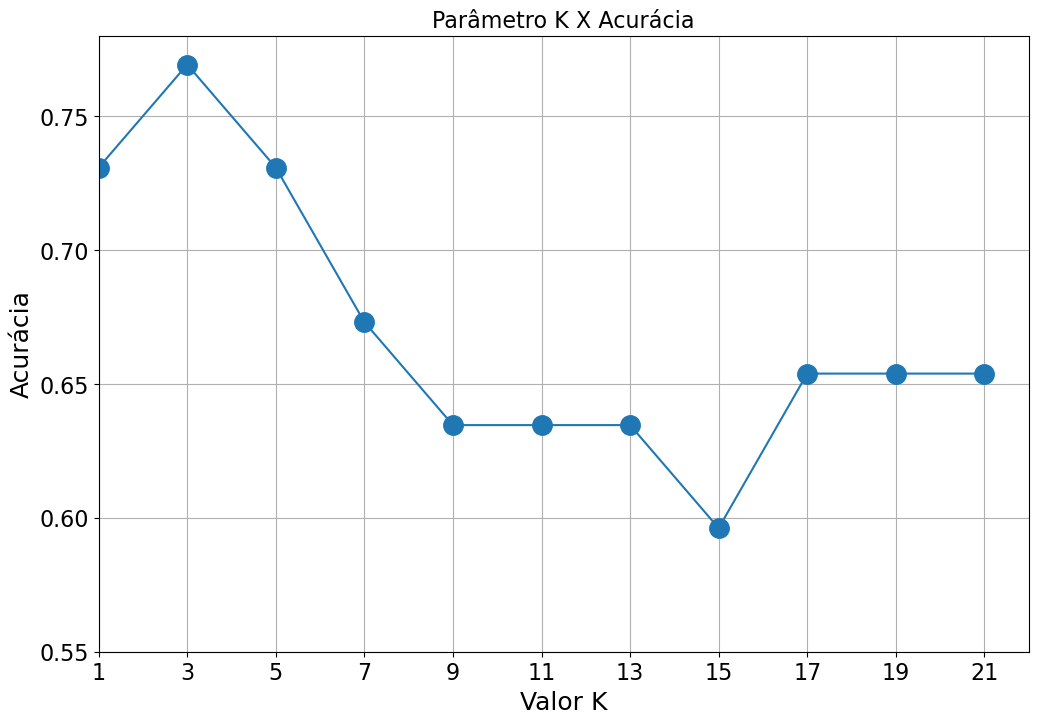

In [72]:
plt.figure(figsize=(12,8))

K_values=[1,3,5,7,9,11,13,15,17,19,21]
Y_pred = np.zeros((len(X_teste),len(K_values)))
contador=0

for k in K_values:
    
    for i in range(len(X_teste)):
        
        Y_pred[i,contador] = KNN(X_train, Y_train, X_teste[i,:], k)
        
    contador+=1
        
KNN_acc_score=[]

for i in range (len(K_values)):
    
    KNN_acc_score.append(accuracy_score(Y_teste, Y_pred[:,i]))
    
plt.plot(K_values, KNN_acc_score, marker='o', markersize=14)

plt.xlim([min(K_values),max(K_values)+1])

plt.ylim([0.55, 0.78])

plt.xlabel("Valor K", fontsize=18)


plt.ylabel("Acurácia",fontsize=18)

plt.grid()

plt.xticks(K_values, fontsize=16)

plt.yticks(fontsize=16)

plt.title('Parâmetro K X Acurácia', fontsize=16)


###  4.2 K-vizinhos mais próximos (KNN) | Teste


<font size=4.25>
    
<p style='text-align: justify;'>
Com o valor de K em mãos, semelhantemente a MLP e a SVM, levantou-se a matriz de confusão bem como as métricas tradicionalmente usadas em problemas de classificação, tais como: sensibilidade, acurácia, precisão e o F1 Score. Ao se observar a matriz de confusão bem como o gráfico de barras com as métricas citadas, nota-se que a modelagem KNN tende a não classificar tão bem as amostras de teste se comparado às demais modelagens abordadas ao longo deste projeto. 
</p>

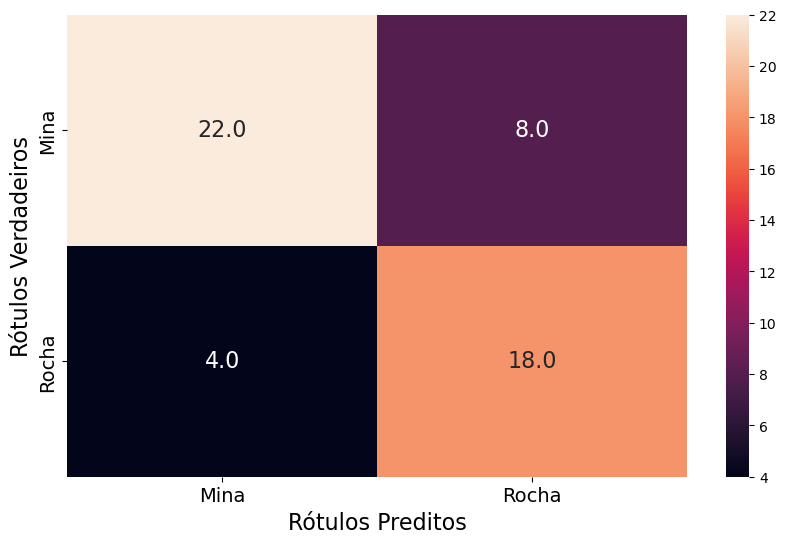

In [25]:
predictions_KNN = Y_pred[:,np.argmax(KNN_acc_score)] 

gera_confusion_matrix(predictions_KNN, Y_teste)

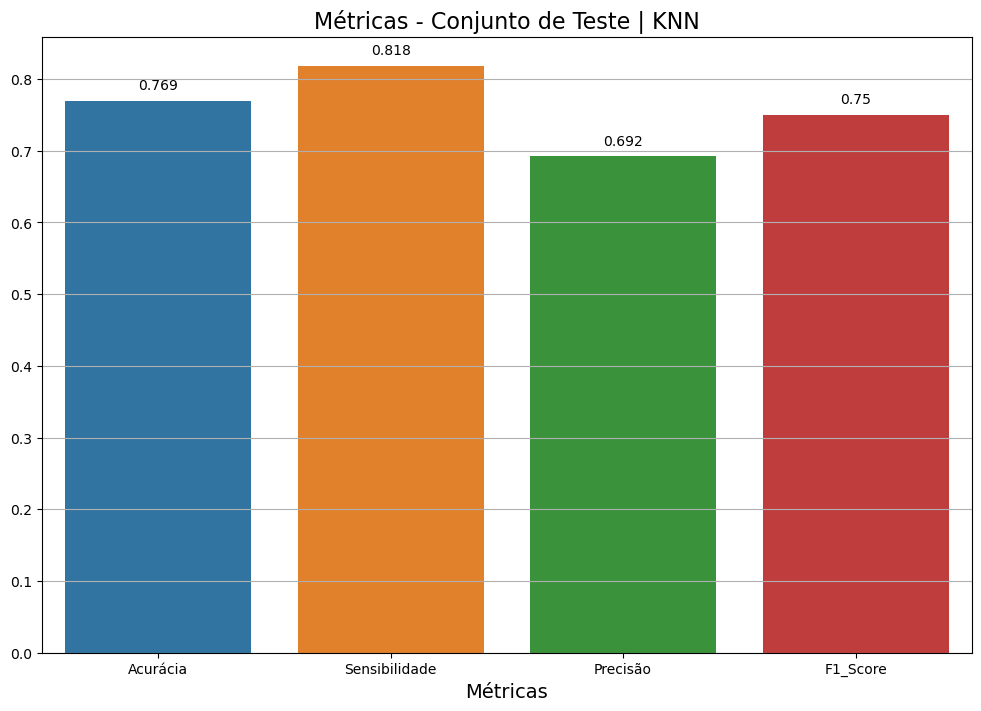

In [79]:
plot_metrics_test (predictions_KNN, Y_teste, nome_modelo = 'KNN')

###  5.0 Conclusões

<font size=4.25>
<p style='text-align: justify;'>
A partir dos gráficos de barra abaixo, sumariamente, nota-se que a rede neural apresentou o melhor de desempenho em relação à classificação das amostras de teste. Ao se observar o processo de validação cruzada, nota-se que arquiteturas mais complexas de redes neurais (com mais camadas e eventualmente neurõnios) não ocasionam aumento significativo da acurácia. Similarmente, nas SVMs constatou-se que o contínuo incremento do parâmetro C também não proporciona um aumento na acurácia. Por outro lado, é fundamental a utilização de funções kernel que captem as não linearidades do banco de dados avaliado. Diferentemente das demais técnicas avaliadas, o KNN não se mostrou um método satisfotariamente capaz de classificar as amostras presentes no conjunto de teste. Conforme apresentado anteriormente, indica-se a utilização de valores de k mais baixos uma vez que a formação de regiões mais isoladas para cada classe (Mina e Rocha) tende a melhor compreender a distribuição das amostras no domínio do problema. 
</p>

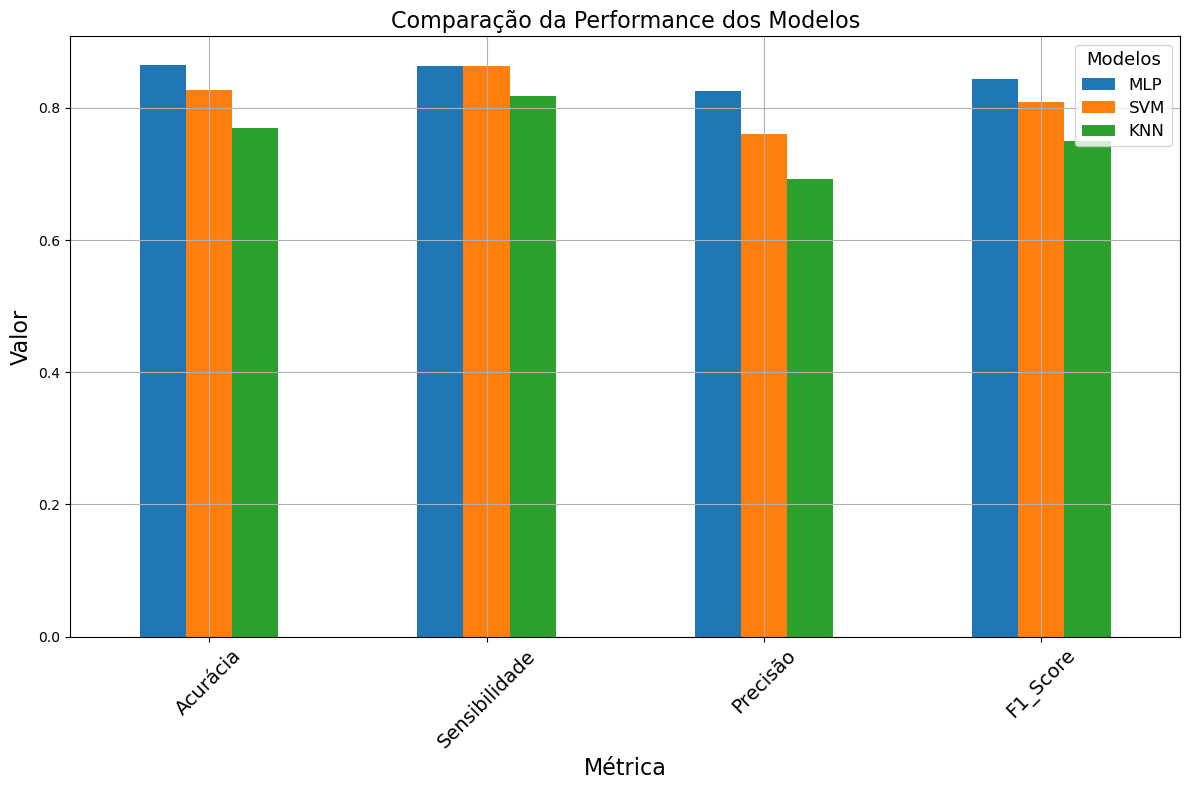

In [81]:
metrics_index = ['Acurácia', 'Sensibilidade', 'Precisão', 'F1_Score']

models_list = ['MLP', 'SVM', 'KNN']

models ={}

for model in models_list:
    
    metrics_values=[]

    for metric in [accuracy_score, recall_score, precision_score, f1_score]:
        
        if model == 'MLP':

            metrics_values.append(np.round(metric(Y_teste, predictions_MLP),3))
            
        elif model == 'SVM':
            
            metrics_values.append(np.round(metric(Y_teste, predictions_SVM,),3))
            
        else:
            
             metrics_values.append(np.round(metric(Y_teste, predictions_KNN),3))
            

    models[model] = metrics_values
    
df_metrics = pd.DataFrame(models, index=metrics_index)

fig, ax = plt.subplots(figsize=(12, 8))
df_metrics.plot(kind='bar', ax=ax)
plt.grid()
ax.set_xlabel('Métrica', fontsize=16)
ax.set_ylabel('Valor', fontsize=16)
ax.set_title('Comparação da Performance dos Modelos', fontsize=16)
ax.set_xticklabels(metrics_index, rotation=45,fontsize=14)
plt.legend(title='Modelos', title_fontsize='13', fontsize='12', loc=1)
plt.tight_layout()

plt.show()

###  6.0 Referências

<font size=4.25>
<p style='text-align: justify;'>
[1] Jeatrakul and K. W. Wong, “Comparing the Performance of Different Neural Networks for Binary Classifica- tion Problems,” The 8th International Symposium on Na- tural Language Processing, Bangkok, 20-22 October 2009, pp.111-115;
</p>
  
<font size=4.25>
<p style='text-align: justify;'>
[2] P. Kraipeerapun, "Neural network classification based on quantification of uncertainty," Murdoch University, 2008.
</p>
    
<font size=4.25>
<p style='text-align: justify;'>    
[3] UCI – Machine Learning Repository, disponível em: https//archives.ics.uci.edu/ml/datastets
</p>

<font size=4.25>
<p style='text-align: justify;'>
[4] Gorman, R. P., and Sejnowski, T. J. (1988). "Analysis of Hidden Units in a Layered Network Trained to Classify Sonar.
</p>   
    
    
<font size=4.25>
<p style='text-align: justify;'>
[5] Bocatto, L. & Attux, R. Notas de Aula - Máquinas de Vetores-Suporte, disponível em: https://www.dca.fee.unicamp.br/~lboccato/topico_7.1_SVM.pdf
</p>
    
<font size=4.25>
<p style='text-align: justify;'>
[6] Géron, A. Mãos à Obra: Aprendizado de Máquina com Scikit-Learn, Keras & TensorFlow. AltaBooks Editora, 2021.
</p>